In [2]:
# Preliminary stuff
import pandas as pd
import os
import ast
import numpy as np
import math
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import pickle
from Bio import pairwise2
from Bio import SeqIO
from Bio.SubsMat import MatrixInfo as matlist
import seaborn as sns
from scipy.stats import kendalltau

In [3]:
CHARACTER_DICT = set([u'A', u'C', u'E', u'D', u'G', u'F', u'I', u'H', u'K', u'M', u'L', u'N', u'Q', u'P', u'S', u'R', u'T', u'W', u'V', u'Y'])
MAX_SEQUENCE_LENGTH=46
MAX_MIC = 4
FONT_TO_USE = 'Arial'

In [4]:
# Enter an element of a result dictionary into df-ready row
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None
    
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

# However, C-Terminal Amidation is common enough that we make an exception
CTERM_AMIDATION_TERMS = ['C-Terminal amidation','C-Terminus: AMD','C-Terminal','C-termianal amidation']

def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

def has_unusual_modification(modifications_list):
    return any([is_uncommon_modification(mod) for mod in modifications_list])

def has_cterminal_amidation(modifications_list):
    return any([is_cterminal_amidation(mod) for mod in modifications_list])

def has_disulfide_bonds(modifications_list):
    return any([is_disulfide_bond(mod) for mod in modifications_list])

def is_cterminal_amidation(mod):
    for term in CTERM_AMIDATION_TERMS:
        if term in mod:
            return True
    return False

def is_disulfide_bond(mod):
    return 'disulfide' in mod.lower()

def is_uncommon_modification(mod):
    return (not is_cterminal_amidation(mod)) and (not is_disulfide_bond(mod))

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

index2character = {
    value: key
    for key, value in character_to_index.items()
}

def sequence_to_vector(sequence, cterminal_amidation):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
    if len(sequence)<MAX_SEQUENCE_LENGTH:
        default[len(sequence)][-1]=cterminal_amidation
    return default

def old_sequence_to_vector(sequence, cterminal_amidation):
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    return sequence_to_vector(sequence,cterminal_amidation)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_amidation']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5
    
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df.reset_index()

def split_dataframe(df_to_split,cutoff=0.85):
    train_indices = []
    test_indices = []
    for i in range(len(df_to_split)):
        if 'C' not in df_to_split['sequence'][i] and random.random()>cutoff:
            test_indices.append(i)
        else:
            train_indices.append(i)
    train_df = df_to_split.iloc[train_indices]
    test_df = df_to_split.iloc[test_indices]
    return train_df, test_df

In [5]:
for i,seq in enumerate(df.sequence):
#     if seq == 'DAHKLAKLAKKLAKLAK':
#     if seq == 'KWWRWRRWW':
    if seq == 'FKCWRWQWRWKKLGAKVFKRLEKLFSKI':
        print df[i:i+1]

NameError: name 'df' is not defined

In [ ]:
plt.hist(ecoli_df.value,bins=30)
plt.show()
less = 0
more = 0
for val in ecoli_df.value:
    if val < 0.1938:
        less += 1
    else:
        more +=1
print less
print more
print float(less)/(less+more)

In [6]:
df[0:1]

NameError: name 'df' is not defined

In [7]:
# The scripts stored the outputs as dictionaries.
all_results = []
for f in os.listdir('.'):
    if '.data' in f:
        with open(f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))
            
# Load all the rows into an array         
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)
            
# Construct the df
df = pd.DataFrame(rows)

print("Dataframe length before removing bad chars:", len(df))

for bad_char in ['U', 'X', 'Z']:
    df = strip_sequences_with_char(df, bad_char)
print("Dataframe length after removing bad chars:", len(df))

df['is_modified'] = df.modifications.apply(is_modified)
df['has_unusual_modification'] = df.modifications.apply(has_unusual_modification)
df['has_cterminal_amidation'] = df.modifications.apply(has_cterminal_amidation)

# Clean sequences by removing newlines and one improper sequence
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

# Exclude sequences with modifications
# Exclude rows from YADAMP and CAMP for having no modification data
#     Unless that sequence is in another DB

df = df.loc[df.has_unusual_modification == False]


no_modification_data_sources = ['camp3', 'yadamp']

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])


df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

# Correct typos, for example, 'P. aeruginsa'
df=df.reset_index()
typos=['K. pneumonia','P. aeruginsa','S. aureu','S. a']
corrections = ['K. pneumoniae','P. aeruginosa','S. aureus','S. aureus']
for k,bacterium in enumerate(df['bacterium']):
    for i in range(len(typos)):
        if bacterium == typos[i]:
            df.at[k,'bacterium']=corrections[i]

('Dataframe length before removing bad chars:', 62494)
('Dataframe length after removing bad chars:', 57697)


In [46]:
for i,test_seq in enumerate(df.sequence):
    if 'FLPIVGKLLSGLL' in test_seq:
        print test_seq
        print i
# df[381:382]
df[47320:47321]
# print df[47319:47321]

FLPIVGKLLSGLL
381
FLPIVGKLLSGLL
25895
FLPIVGKLLSGLL
25896
FLPIVGKLLSGLL
25897
FLPIVGKLLSGLL
25898
FLPIVGKLLSGLL
47319
FLPIVGKLLSGLL
47320


,index,bacterium,modifications,sequence,strain,unit,url_source,value,is_modified,has_unusual_modification,has_cterminal_amidation,_datasource_has_modifications,_sequence_has_modifications,modification_verified
47320,58510,E. coli,[],FLPIVGKLLSGLL,None,uM,http://www.yadamp.unisa.it/showItem.aspx?yadampid=317,2.11,False,False,False,False,True,True


In [8]:
# Correlation analysis between bacteria
Ec = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
Sa = df.loc[df.bacterium.str.contains('S. aureus')].groupby('sequence')['value'].mean().dropna()
Pa = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
Sm = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
Bs = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()
Se = df.loc[df.bacterium.str.contains('S. epidermidis')].groupby('sequence')['value'].mean().dropna()
Ml = df.loc[df.bacterium.str.contains('M. luteus')].groupby('sequence')['value'].mean().dropna()
Kp = df.loc[df.bacterium.str.contains('K. pneumoniae')].groupby('sequence')['value'].mean().dropna()
Ef = df.loc[df.bacterium.str.contains('E. faecalis')].groupby('sequence')['value'].mean().dropna()
St = df.loc[df.bacterium.str.contains('S. typhimurium')].groupby('sequence')['value'].mean().dropna()
Ca = df.loc[df.bacterium.str.contains('C. albicans')].groupby('sequence')['value'].mean().dropna()

In [9]:
# Show the correlation between bacteria
# Note that Gram-Positivity seems to have a strong effect on correlation
# E. coli and pseudomonas are highly correlated
# While neither is correlated with streptococcus, staph or bacillus
# Meanwhile, staph and streptococcus are strongly correlated as expected
# As are bacillus and streptococcus
# The lack of correlation between bacillus and staph is a mystery to me
many_bacteria = pd.concat([Ca,Pa,Ec,Kp,St,Ml,Ef,Bs,Se,Sa], axis=1).reset_index()
many_bacteria.columns = ['index', 'Ca','Pa', 'Ec','Kp','St','Ml','Ef','Bs','Se','Sa']
corr=many_bacteria.corr(min_periods=50)
corr

,Ca,Pa,Ec,Kp,St,Ml,Ef,Bs,Se,Sa
Ca,1.00,0.52,0.59,0.51,0.43,0.56,0.63,0.47,0.55,0.64
Pa,0.52,1.00,0.78,0.79,0.82,0.52,0.63,0.60,0.66,0.65
Ec,0.59,0.78,1.00,0.87,0.87,0.62,0.59,0.69,0.70,0.67
Kp,0.51,0.79,0.87,1.00,0.93,0.64,0.45,0.64,0.68,0.69
St,0.43,0.82,0.87,0.93,1.00,0.50,0.76,0.56,0.66,0.74
Ml,0.56,0.52,0.62,0.64,0.50,1.00,0.81,0.76,0.73,0.64
Ef,0.63,0.63,0.59,0.45,0.76,0.81,1.00,0.64,0.77,0.78
Bs,0.47,0.60,0.69,0.64,0.56,0.76,0.64,1.00,0.82,0.67
Se,0.55,0.66,0.70,0.68,0.66,0.73,0.77,0.82,1.00,0.80
Sa,0.64,0.65,0.67,0.69,0.74,0.64,0.78,0.67,0.80,1.00


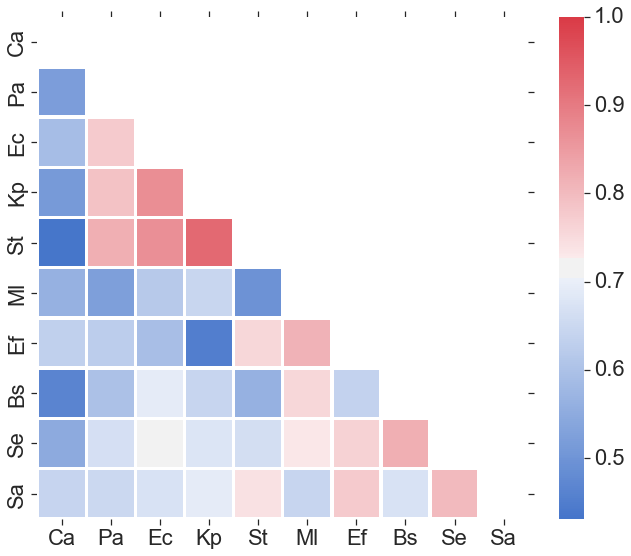

In [10]:
# sns.set()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(255, 10, as_cmap=True)
sns.set(font_scale=2,style='white',font=FONT_TO_USE)
# sns.set_style({'font.sans-serif': 'arial'})
f, ax = plt.subplots(figsize=(11,9))
# sns.set_style({'font.sans-serif': ['Arial']})
hmp=sns.heatmap(corr,mask=mask,linewidth=2.5,cmap=cmap)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
# sns.set_style({'font.sans-serif': ['Arial']})
fig = hmp.get_figure()
fig.savefig('Figures/Heatmap.png')

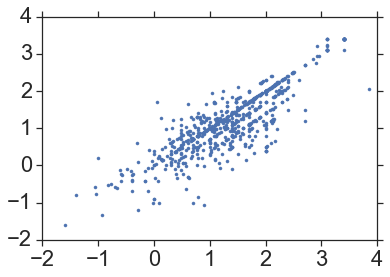

4559


In [15]:
plt.plot(many_bacteria.Kp,many_bacteria.Ec,'.')
plt.show()
print len(Ec)

In [244]:
Msmeg = df.loc[df.bacterium.str.contains('M. smegmatis')].groupby('sequence')['value'].mean().dropna()
Mtub = df.loc[df.bacterium.str.contains('M. tuberculosis')].groupby('sequence')['value'].mean().dropna()
Bcep = df.loc[df.bacterium.str.contains('B. cepacia')].groupby('sequence')['value'].mean().dropna()
Bcen = df.loc[df.bacterium.str.contains('B. cenocepacia')].groupby('sequence')['value'].mean().dropna()
Mabs = df.loc[df.bacterium.str.contains('M. abscessus')].groupby('sequence')['value'].mean().dropna()
Mav = df.loc[df.bacterium.str.contains('M. avium')].groupby('sequence')['value'].mean().dropna()
print len(Msmeg)
print len(Mtub)
print len(Mabs)
print len(Mav)
print len(Bcep)
print len(Bcen)

55
37
1
3
29
2


In [187]:
rare_bact = pd.concat([Pa,Ec,Kp,St,Bcep,Msmeg,Mtub], axis=1).reset_index()
rare_bact.columns = ['index', 'Pa', 'Ec','Kp','St','Bcep','Msmeg','Mtub']
corr = rare_bact.corr(min_periods=10)
print corr

        Pa   Ec   Kp   St  Bcep  Msmeg  Mtub
Pa    1.00 0.78 0.79 0.82  0.68   0.87  0.48
Ec    0.78 1.00 0.87 0.87  0.41   0.48  0.21
Kp    0.79 0.87 1.00 0.93   nan    nan   nan
St    0.82 0.87 0.93 1.00  0.40    nan   nan
Bcep  0.68 0.41  nan 0.40  1.00    nan   nan
Msmeg 0.87 0.48  nan  nan   nan   1.00  0.70
Mtub  0.48 0.21  nan  nan   nan   0.70  1.00


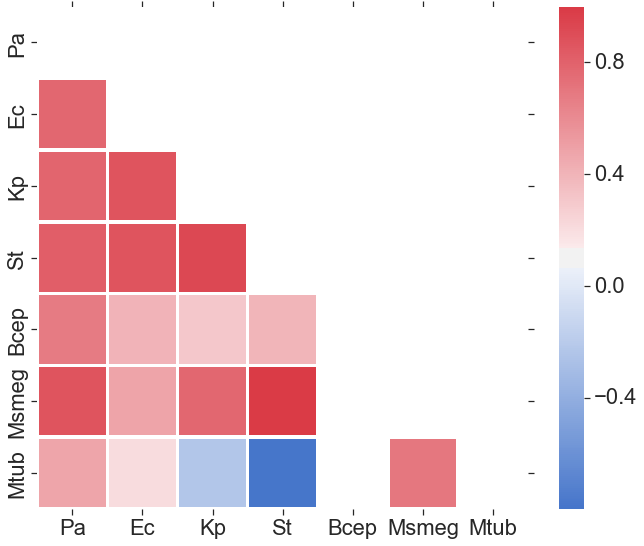

In [185]:
# sns.set()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(255, 10, as_cmap=True)
sns.set(font_scale=2,style='white',font=FONT_TO_USE)
# sns.set_style({'font.sans-serif': 'arial'})
f, ax = plt.subplots(figsize=(11,9))
# sns.set_style({'font.sans-serif': ['Arial']})
hmp=sns.heatmap(corr,mask=mask,linewidth=2.5,cmap=cmap)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
# sns.set_style({'font.sans-serif': ['Arial']})
fig = hmp.get_figure()
plt.show()

In [189]:
all_interesting_bacteria = pd.concat([Pa,Ec,Kp,St,Ml,Ef,Bs,Se,Sa,Bcep,Msmeg,Mtub], axis=1).reset_index()
all_interesting_bacteria.columns = ['Sequence', 'P_aeruginosa', 'E_coli','K_pneumoniae','S_typhimurium','M_luteus','E_faecalis','B_subtilis','S_epidermidis','S_aureus','B_cepacia','M_smegmatis','M_tuberculosis']
all_interesting_bacteria.to_csv('Saved_variables/all_interesting_bacteria.csv')

# Don't need to run this because it's already been run

In [146]:
# ecoli_train.to_pickle('Saved_variables/ecoli_train_with_c_df.pkl')
# ecoli_train_no_c.to_pickle('Saved_variables/ecoli_train_no_c_df.pkl')
# ecoli_test.to_pickle('Saved_variables/ecoli_test_df.pkl')
# ecoli_df.to_pickle('Saved_variables/ecoli_all_df.pkl')
# ecoli_df_no_c.to_pickle('Saved_variables/ecoli_all_no_c_df.pkl')
# df.to_pickle('Saved_variables/all_df.pkl')

# This is where I should be starting: read off the pickled data

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import json
from keras.models import model_from_json

/Users/jacobwitten/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
ecoli_train_with_c = pd.read_pickle('Saved_variables/ecoli_train_with_c_df.pkl')
ecoli_train_no_c = pd.read_pickle('Saved_variables/ecoli_train_no_c_df.pkl')
ecoli_test = pd.read_pickle('Saved_variables/ecoli_test_df.pkl')
ecoli_df = pd.read_pickle('Saved_variables/ecoli_all_df.pkl')
ecoli_df_no_c = pd.read_pickle('Saved_variables/ecoli_all_no_c_df.pkl')
all_df = pd.read_pickle('Saved_variables/all_df.pkl')

In [150]:
print len(ecoli_train_with_c)
print len(ecoli_train_no_c)
print len(ecoli_test)
print (len(ecoli_test)+len(ecoli_train_with_c))
print len(ecoli_df)
print (len(ecoli_test)+len(ecoli_train_no_c))
print len(ecoli_df_no_c)
print (len(ecoli_df)-len(ecoli_df_no_c))

4050
2895
509
4559
4559
3404
3404
1155


In [17]:
print len(ecoli_df)
print len(ecoli_df_no_c)
print repr(len(ecoli_df)-len(ecoli_df_no_c))
print repr(1-float(len(ecoli_df_no_c))/len(ecoli_df))

4559
3404
1155
0.2533450318052204


In [67]:
# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
def df_to_input_vec(df,shuffle = False):
    cterminal_amidation = np.array(df.has_cterminal_amidation)

    vectors = []
    for row in df.iterrows():
        vectors.append(row_to_vector(row[1], shuffle_sequence=shuffle))

    vectors = np.array(vectors)

    labels = np.array(df.value)
    sample_weights = np.full(len(labels), 1)
    return vectors, labels, sample_weights

def generate_random_sequence(alphabet, length_of_sequence_min=0, length_of_sequence_max=MAX_SEQUENCE_LENGTH, include_C = True,fixed_length=-10,just_seq=False):
#         Generates a random sequence to match the sequence length distribution of the test dataset
        sequence = ''
        choices = [char for char in alphabet if (include_C or char !='C')]
        counter = 0
        length_to_use = -10
        if fixed_length<0:
            while counter<20 and (length_to_use < length_of_sequence_min or length_to_use > length_of_sequence_max):
                length_to_use = random.choice(SEQ_LENGTHS)
                counter += 1
        else:
            length_to_use = fixed_length
        for _ in range(length_to_use):
            sequence += random.choice(choices)
        if just_seq:
            return sequence
        has_cterminal_amidation = random.uniform(0, 1)
        
        return {
            'sequence': sequence,
            'has_cterminal_amidation': has_cterminal_amidation>0.5
#             Used to be 0.5 but only 34% of positive data has amidation OOPS
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None, include_cysteine = True):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT),include_C = include_cysteine)))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

# Convolutional NN
def conv_model():
    model = keras.models.Sequential()
    model.add(ZeroPadding1D(
        5, input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        #input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

class EnsembleModel:
    def __init__(self,models,predict_method,max_mic_buffer=0.1):
        self.models = models
        self.predict_method = predict_method
        self.max_mic_buffer = max_mic_buffer
        
    def combine_predictions(self,predictions):
        if self.predict_method is 'average':
            return np.mean(predictions)
        elif self.predict_method is 'classify_then_average':
            actual_predictions = []
            for prediction in predictions:
                if prediction < MAX_MIC - self.max_mic_buffer:
                    actual_predictions.append(prediction)
            if float(len(actual_predictions))/float(len(predictions))>=0.49:
                return np.mean(predictions)
            else:
                return MAX_MIC
        else:
            print 'predict_method not recognized'
            return -100
        
    def predict(self,test_x):
        all_predictions = []
        combined_predictions = []
        for model in self.models:
            all_predictions.append(model.predict(test_x))
        for i in range(len(test_x)):
            combined_predictions.append(self.combine_predictions([all_predictions[k][i] for k in range(len(self.models))]))
        return combined_predictions
    
    def evaluate(self,test_x,test_y):
        predictions = self.predict(test_x)
        correctly_classified_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC and predicted < MAX_MIC - self.max_mic_buffer])    
        all_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions)])    
        all_active_error = np.mean([(actual - predicted) ** 2 for actual, predicted in zip(test_y, predictions) if actual < MAX_MIC])    
        return correctly_classified_error,all_active_error, all_error
    
    def evaluate_as_classifier(self,test_x,test_y):
        true_positives=0
        true_negatives=0
        false_positives=0
        false_negatives=0
        all_predicted=self.predict(test_x)
        for i in range(len(test_y)):
            actual=test_y[i]
            predicted=all_predicted[i]
            if actual<MAX_MIC-0.0001:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    true_positives+=1
                else:
                    false_negatives+=1
            else:
                if predicted<MAX_MIC - self.max_mic_buffer:
                    false_positives += 1
        #             print vector_to_amp(test_x[i])
        #             print 'predicted: '+repr(predicted)+', actual: '+repr(actual)
#                     print '>p'+repr(false_positives)+'_'+repr(predicted)
#                     print vector_to_amp(test_x[i])['sequence'].replace('_','')
                else:
                    true_negatives += 1
        return true_positives,true_negatives,false_positives,false_negatives
        
                                             

In [68]:
ecoli_train_with_c_input = df_to_input_vec(ecoli_train_with_c)
ecoli_train_no_c_input = df_to_input_vec(ecoli_train_no_c)
ecoli_test_input = df_to_input_vec(ecoli_test)
ecoli_df_with_c_input = df_to_input_vec(ecoli_df)
ecoli_df_no_c_input = df_to_input_vec(ecoli_df_no_c)

seqs = ecoli_df.sequence
lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
SEQ_LENGTHS = lengths

ecoli_test_input_with_negatives = add_random_negative_examples(ecoli_test_input[0],ecoli_test_input[1],ecoli_test_input[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)

vectors = ecoli_test_input_with_negatives[0]
labels = ecoli_test_input_with_negatives[1]
average = np.mean(labels)
squared_errors = sum([(label - average) ** 2 for label in labels])
baseline_error = squared_errors/len(labels)
print("Baseline error:")
print(baseline_error)
measured_labels = [l for l in labels if l < MAX_MIC]
average = np.mean(measured_labels)
squared_errors = sum([(label - average) ** 2 for label in measured_labels])
baseline_error = squared_errors/len(measured_labels)
print("Baseline error on measured examples only")
print(baseline_error)



Baseline error:
2.316011504218598
Baseline error on measured examples only
0.6112859742513107


# Generate sequences and save in a FASTA file to compare to other guys

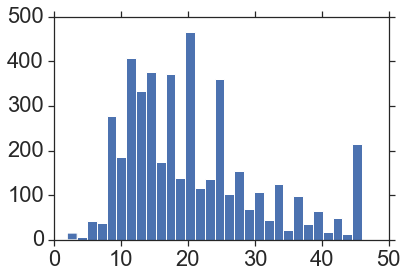

In [14]:
# seqs = ecoli_df.sequence
# lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
plt.hist(SEQ_LENGTHS,bins=30)
plt.show()
labels = ecoli_test_input_with_negatives[1]
seqs_for_fasta = []
for vect in ecoli_test_input_with_negatives[0]:
    seq = vector_to_amp(
        
        vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)

In [15]:
np.sum(ecoli_df.has_cterminal_amidation)/len(ecoli_df.has_cterminal_amidation)

0.3408440369067699

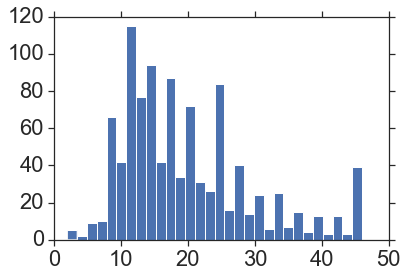

In [195]:
plt.hist([len(seq) for seq in seqs_for_fasta],bins=30)
plt.show()
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives.txt','w')
test_file.write(for_fasta)
test_file.close()
# for seq in seqs:
# len(new_seq)-new_seq.count('_')

In [216]:
less = 0
as_much = 0
for i,vect in enumerate(ecoli_test_input_with_negatives[0]):
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
#     print seq
    if len(seq)<MAX_SEQUENCE_LENGTH:
        less+=1
    else:
        print i
        as_much += 1
print less
print as_much
print less+as_much
print 34.0/1018

0
97
110
348
372
375
393
435
458
460
522
575
585
592
657
678
696
710
762
766
791
792
809
828
841
856
887
898
903
936
977
989
992
1015
984
34
1018
0.0333988212181


In [198]:
less = 0
as_much = 0
for vect in ecoli_test_input_with_negatives[0]:
    if len(seq)<MAX_SEQUENCE_LENGTH:
        less+=1
    else:
        as_much += 1
print less
print as_much
print less+as_much
print 34.0/1018

1018
0
1018
0.0333988212181


In [35]:
# Train an ensemble of models with cysteines included, generating a new set of negative data each time
NEGATIVE_RATIO = 30
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_train_with_c_input_with_negatives = add_random_negative_examples(ecoli_train_with_c_input[0],ecoli_train_with_c_input[1],ecoli_train_with_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=True)
    weights_fname = 'Saved_models/train_ensemble_weights_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/train_ensemble_architecture_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_train_with_c_input_with_negatives[0], ecoli_train_with_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

Epoch 1/100
125550/125550 [==============================] - 50s 399us/step - loss: 0.2232
Epoch 2/100
125550/125550 [==============================] - 46s 370us/step - loss: 0.0803
Epoch 3/100
125550/125550 [==============================] - 51s 406us/step - loss: 0.0600
Epoch 4/100
125550/125550 [==============================] - 48s 379us/step - loss: 0.0542
Epoch 5/100
125550/125550 [==============================] - 45s 356us/step - loss: 0.0478
Epoch 6/100
125550/125550 [==============================] - 45s 358us/step - loss: 0.0451
Epoch 7/100
125550/125550 [==============================] - 45s 359us/step - loss: 0.0413
Epoch 8/100
125550/125550 [==============================] - 51s 404us/step - loss: 0.0389
Epoch 9/100
125550/125550 [==============================] - 46s 367us/step - loss: 0.0371
Epoch 10/100
125550/125550 [==============================] - 45s 356us/step - loss: 0.0339
Epoch 11/100
125550/125550 [==============================] - 46s 365us/step - loss: 0.03

In [126]:
# Train an ensemble of models without cysteines included, generating a new set of negative data each time
all_conv_models=[]
NEGATIVE_RATIO = 30
ENSEMBLE_SIZE=5
done=0
for i in range(done,ensemble_size):
    ecoli_train_no_c_input_with_negatives = add_random_negative_examples(ecoli_train_no_c_input[0],ecoli_train_no_c_input[1],ecoli_train_no_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=False)
    weights_fname = 'Saved_models/train_ensemble_weights_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/train_ensemble_architecture_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_train_no_c_input_with_negatives[0], ecoli_train_no_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

Epoch 1/100
5790/5790 [==============================] - 4s 692us/step - loss: 1.4842
Epoch 2/100
5790/5790 [==============================] - 2s 392us/step - loss: 0.7554
Epoch 3/100
5790/5790 [==============================] - 2s 399us/step - loss: 0.6200
Epoch 4/100
5790/5790 [==============================] - 2s 402us/step - loss: 0.5110
Epoch 5/100
5790/5790 [==============================] - 2s 420us/step - loss: 0.4481
Epoch 6/100
5790/5790 [==============================] - 2s 427us/step - loss: 0.3933
Epoch 7/100
5790/5790 [==============================] - 2s 418us/step - loss: 0.3528
Epoch 8/100
5790/5790 [==============================] - 2s 373us/step - loss: 0.3087
Epoch 9/100
5790/5790 [==============================] - 2s 398us/step - loss: 0.2935
Epoch 10/100
5790/5790 [==============================] - 3s 443us/step - loss: 0.2581
Epoch 11/100
5790/5790 [==============================] - 2s 393us/step - loss: 0.2443
Epoch 12/100
5790/5790 [============================

In [36]:
# Train an ensemble of models with cysteines included, with all the data
NEGATIVE_RATIO = 3
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_df_with_c_input_with_negatives = add_random_negative_examples(ecoli_df_with_c_input[0],ecoli_df_with_c_input[1],ecoli_df_with_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=True)
    weights_fname = 'Saved_models/all_data_ensemble_weights_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/all_data_ensemble_architecture_withC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_df_with_c_input_with_negatives[0], ecoli_df_with_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

Epoch 1/100
18236/18236 [==============================] - 8s 436us/step - loss: 1.0612
Epoch 2/100
18236/18236 [==============================] - 7s 370us/step - loss: 0.4753
Epoch 3/100
18236/18236 [==============================] - 6s 351us/step - loss: 0.3648
Epoch 4/100
18236/18236 [==============================] - 6s 329us/step - loss: 0.3083
Epoch 5/100
18236/18236 [==============================] - 7s 389us/step - loss: 0.2637
Epoch 6/100
18236/18236 [==============================] - 8s 420us/step - loss: 0.2338
Epoch 7/100
18236/18236 [==============================] - 7s 387us/step - loss: 0.2080
Epoch 8/100
18236/18236 [==============================] - 7s 379us/step - loss: 0.1871
Epoch 9/100
18236/18236 [==============================] - 6s 346us/step - loss: 0.1750
Epoch 10/100
18236/18236 [==============================] - 7s 381us/step - loss: 0.1518
Epoch 11/100
18236/18236 [==============================] - 7s 389us/step - loss: 0.1425
Epoch 12/100
18236/18236 [====

In [33]:
# Train an ensemble of models without cysteines included, with all the data
NEGATIVE_RATIO = 1
all_conv_models=[]
ensemble_size=5
done=0
for i in range(done,ensemble_size):
    ecoli_df_no_c_input_with_negatives = add_random_negative_examples(ecoli_df_no_c_input[0],ecoli_df_no_c_input[1],ecoli_df_no_c_input[2],ratio=NEGATIVE_RATIO,max_mic=MAX_MIC,include_cysteine=False)
    weights_fname = 'Saved_models/all_data_ensemble_weights_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.h5'
    architecture_fname = 'Saved_models/all_data_ensemble_architecture_noC_'+repr(NEGATIVE_RATIO)+'xneg_'+repr(i)+'.json'
    convmodel = conv_model()
    convmodel.fit(ecoli_df_no_c_input_with_negatives[0], ecoli_df_no_c_input_with_negatives[1], batch_size=40, epochs=100)
    convmodel.save_weights(weights_fname)
    with open(architecture_fname,'w') as f:
        f.write(convmodel.to_json())
    all_conv_models.append(convmodel)

Epoch 1/100
6808/6808 [==============================] - 3s 508us/step - loss: 1.3543
Epoch 2/100
6808/6808 [==============================] - 3s 413us/step - loss: 0.7543
Epoch 3/100
6808/6808 [==============================] - 3s 426us/step - loss: 0.6188
Epoch 4/100
6808/6808 [==============================] - 3s 412us/step - loss: 0.5415
Epoch 5/100
6808/6808 [==============================] - 3s 438us/step - loss: 0.4595
Epoch 6/100
6808/6808 [==============================] - 3s 438us/step - loss: 0.4047
Epoch 7/100
6808/6808 [==============================] - 3s 441us/step - loss: 0.3610
Epoch 8/100
6808/6808 [==============================] - 3s 473us/step - loss: 0.3285
Epoch 9/100
6808/6808 [==============================] - 3s 456us/step - loss: 0.2924
Epoch 10/100
6808/6808 [==============================] - 3s 482us/step - loss: 0.2764
Epoch 11/100
6808/6808 [==============================] - 3s 438us/step - loss: 0.2435
Epoch 12/100
6808/6808 [============================

In [101]:
ENSEMBLE_SIZE=5
NEG_RATIOS = [1,3,10]
with_C_weights = []
with_C_architectures = []
no_C_weights = []
no_C_architectures = []
for k in range(len(NEG_RATIOS)):
    with_C_weights.append(['train_ensemble_weights_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    with_C_architectures.append(['train_ensemble_architecture_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])   
#     no_C_weights.append(['train_ensemble_weights_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
#     no_C_architectures.append(['train_ensemble_architecture_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])



In [106]:
with_C_architectures[0][0]

'train_ensemble_architecture_withC_1xneg_0.json'

In [102]:
test_x = ecoli_test_input_with_negatives[0]
test_y = ecoli_test_input_with_negatives[1]
with_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
no_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
for k in range(len(NEG_RATIOS)):
    for i in range(len(with_C_weights[0])):
        print k
        print i
        with open('Saved_models/'+with_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+with_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        with_c_ensembles[k].append(reconst_model)    

        with open('Saved_models/'+no_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+no_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        no_c_ensembles[k].append(reconst_model)
                             


0
0


IndexError: list index out of range

In [53]:
no_c_ensemble_models = [EnsembleModel(no_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_models = [EnsembleModel(with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
no_c_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_model_avgs = [EnsembleModel(with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
all_ensemble_models = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
all_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]

everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'classify_then_average')  
everything_ensemble_model_avg = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')


no_c_ensemble_model_small = [EnsembleModel(no_c_ensembles[k][0:3],'classify_then_average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_model_small = [EnsembleModel(with_c_ensembles[k][0:3],'classify_then_average') for k in range(len(NEG_RATIOS))]
all_ensemble_model_small = [EnsembleModel(no_c_ensembles[k][0:3]+with_c_ensembles[k][0:3],'average') for k in range(len(NEG_RATIOS))]

for k in range(len(NEG_RATIOS)):
#     print no_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
#     print no_c_ensemble_models[k].evaluate(test_x,test_y)
    a,b,c,d = with_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
    print with_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
    print 'False negative rate: '+repr(float(d)/a)
    print 'False positive rate: '+repr(float(c)/b)

In [54]:
for k in range(len(NEG_RATIOS)):
#     print no_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
#     print no_c_ensemble_models[k].evaluate(test_x,test_y)
    a,b,c,d = with_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
    print with_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
    print 'False negative rate: '+repr(float(d)/a)
    print 'False positive rate: '+repr(float(c)/b)
#     print with_c_ensemble_models[k].evaluate(test_x,test_y)
#     print all_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
#     print all_ensemble_models[k].evaluate(test_x,test_y)

(494, 4755, 335, 15)
False negative rate: 0.030364372469635626
False positive rate: 0.07045215562565721
(489, 4999, 91, 20)
False negative rate: 0.0408997955010225
False positive rate: 0.01820364072814563
(479, 5055, 35, 30)
False negative rate: 0.06263048016701461
False positive rate: 0.006923837784371909
(450, 5079, 11, 59)
False negative rate: 0.13111111111111112
False positive rate: 0.0021657806654853317


In [121]:
# print no_c_ensemble_model.combine_predictions([-3,3,2,1,1])
print no_c_ensemble_model.evaluate_as_classifier(test_x,test_y)
print with_c_ensemble_model.evaluate_as_classifier(test_x,test_y)
print all_ensemble_model.evaluate_as_classifier(test_x,test_y)
print no_c_ensemble_model.evaluate(test_x,test_y)
print with_c_ensemble_model.evaluate(test_x,test_y)
print all_ensemble_model.evaluate(test_x,test_y)
# print no_c_ensemble_model_avg.evaluate_as_classifier(test_x,test_y)
# print with_c_ensemble_model_avg.evaluate_as_classifier(test_x,test_y)
# print all_ensemble_model_avg.evaluate_as_classifier(test_x,test_y)
# print no_c_ensemble_model_avg.evaluate(test_x,test_y)
# print with_c_ensemble_model_avg.evaluate(test_x,test_y)
# print all_ensemble_model_avg.evaluate(test_x,test_y)
print no_c_ensemble_model_small.evaluate_as_classifier(test_x,test_y)
print with_c_ensemble_model_small.evaluate_as_classifier(test_x,test_y)
print all_ensemble_model_small.evaluate_as_classifier(test_x,test_y)
print no_c_ensemble_model_small.evaluate(test_x,test_y)
print with_c_ensemble_model_small.evaluate(test_x,test_y)
print all_ensemble_model_small.evaluate(test_x,test_y)

(471, 5070, 20, 38)
(479, 5066, 24, 30)
(480, 5069, 21, 29)
(0.31954081546041935, 0.824999670164525, 0.08411778701177455)
(0.3192003973065436, 0.7103093343613873, 0.07412920934377244)
(0.3490234681411962, 0.7155368623841635, 0.07338426449225491)
(472, 5067, 23, 37)
(476, 5065, 25, 33)
(487, 4982, 108, 22)
(0.32424088021271735, 0.800405853380758, 0.08360691394406036)
(0.3227237481137853, 0.7390532560510752, 0.07865077896393473)
(0.3909922215190263, 0.6802317062116057, 0.07376655375337604)


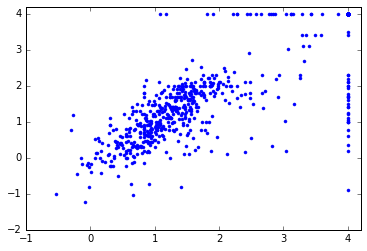

In [110]:
plt.plot(with_c_ensemble_model.predict(test_x),test_y,'.')
plt.ylim(-2,4.2)
plt.xlim(-1,4.2)
plt.show()

# This is the stuff for running the simulated annealing

In [127]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
ENSEMBLE_SIZE=5
NEG_RATIOS = [1,3,10]
with_C_weights = []
with_C_architectures = []
no_C_weights = []
no_C_architectures = []
for k in range(len(NEG_RATIOS)):
    with_C_weights.append(['all_data_ensemble_weights_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    with_C_architectures.append(['all_data_ensemble_architecture_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])
    no_C_weights.append(['all_data_ensemble_weights_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    no_C_architectures.append(['all_data_ensemble_architecture_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])

    
with_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
no_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
for k in range(len(NEG_RATIOS)):
    for i in range(len(with_C_weights[0])):
        with open('Saved_models/'+with_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+with_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        with_c_ensembles[k].append(reconst_model)    

        with open('Saved_models/'+no_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+no_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        no_c_ensembles[k].append(reconst_model)
        
everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')  

In [12]:
scales={'Eisenberg':{'A':  0.25, 'R': -1.80, 'N': -0.64,'D': -0.72, 'C':  0.04, 'Q': -0.69,'E': -0.62, 'G':  0.16, 'H': -0.40,'I':  0.73, 'L':  0.53, 'K': -1.10,'M':  0.26, 'F':  0.61, 'P': -0.07,'S': -0.26, 'T': -0.18, 'W':  0.37,'Y':  0.02, 'V':  0.54},
'Normalized_consensus':{'A':0.62,'C':0.29,'D':-0.9,'E':-0.74,'F':1.19,'G':0.48,'H':-0.4,'I':1.38,'K':-1.5,'L':1.06,'M':0.64,'N':-0.78,'P':0.12,'Q':-0.85,'R':-2.53,'S':-0.18,'T':-.05,'V':1.08,'W':0.81,'Y':0.26}}

def hydrophobic_moment(sequence,scale='Normalized_consensus',angle=0,is_in_degrees=True,normalize=True):
    # Angle should be 100 for alpha helix, 180 for beta sheet
    hscale=scales[scale]
    sin_sum = 0
    cos_sum = 0
    moment=0
    for i in range(len(sequence)):
        hp=hscale[sequence[i]]
        angle_in_radians=i*angle
        if is_in_degrees:
            angle_in_radians = (i*angle)*math.pi/180.0
        sin_sum += hp*math.sin(angle_in_radians)
        cos_sum += hp*math.cos(angle_in_radians)
    moment = math.sqrt(sin_sum**2+cos_sum**2)
    if normalize:
        moment = moment/len(sequence)
    return moment

def evaluate_peptide(peptide, model):
    sequence = peptide['sequence']
    cterm = peptide['has_cterminal_amidation']
    return model.predict(row_to_vector(
        {'sequence': sequence, 'has_cterminal_amidation': int(cterm)}
    ).reshape(-1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1))


def find_nearby_sequences(sequence, old_sequences=None, character_dict=CHARACTER_DICT):
    new_sequences = set()
    if old_sequences == None:
        old_sequences = set()

    for i in range(len(sequence)):
        for c1 in character_dict:
            for j in range(i + 1, len(sequence)):
                for c2 in character_dict:
                    new_sequence = sequence[:i] + c1 + sequence[i+1:j] + c2 + sequence[j+1:]
                    for cterm in (True, False):
                        ns_dict = {'sequence': new_sequence, 'has_cterminal_amidation': cterm}
                        new_sequences.add(frozenset(ns_dict.items()))
    return old_sequences | new_sequences

def evaluate_peptides(peptides, model):
    return model.predict(
        np.array(
            [row_to_vector(dict(p)) for p in peptides]
        ).reshape(
            -1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1
        )
    )

def nearby_peptide_vectors(peptide_vector):
    nearby_vectors = []
    for i in range(len(peptide_vector)):
#         print peptide_vector[i]
        if np.sum(peptide_vector[i][:len(peptide_vector[i])-1])>0.5:
            for j in range(len(peptide_vector[i]) - 1):  # - 1 because of amidation
                v = np.zeros(len(peptide_vector[i]))
                v[-1] = peptide_vector[0][-1]
                v[j] = 1
                new_vector = np.concatenate([
                    peptide_vector[:i],
                    v.reshape(-1, len(peptide_vector[i])),
                    peptide_vector[i+1:]
                ])
                if is_acceptable(vector_to_amp(new_vector)['sequence']):
                    nearby_vectors.append(new_vector)
                else:
                    print 'unacceptable! '+repr(vector_to_amp(new_vector)['sequence'])
#                     cterm_flipped = deepcopy(new_vector)
#                     reverse_cterm = (new_vector[0][-1] + 1) % 2
#                     for c in cterm_flipped:
#                         c[-1] = reverse_cterm
#                     nearby_vectors.append(cterm_flipped)
#         else:
#             print 'Nope!'+repr(i)
    return nearby_vectors

def is_acceptable(sequence_with_padding):
    at_underscore=False
    for char in sequence_with_padding:
        if char == '_':
            at_underscore=True
        elif at_underscore:
            return False
    return True

def generate_sequence(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    for i in range(100):
        vs = nearby_peptide_vectors(v)
        ps = convmodel.predict(np.array(vs))
        best_i = min(range(len(ps)), key=lambda x: ps[x])
        v = vs[best_i]
        if vector_to_amp(v)['sequence']==last:
            break
        last=vector_to_amp(v)['sequence']
    return vector_to_amp(v), ps[best_i][0]

def generate_sequence_from_exp_sequences(sequence_pool,max_generated_length=25):
    sequence=''
    for ind in range(max_generated_length):
#         print len(sequence_pool)
        which_ind = random.randint(0,len(sequence_pool)-1)
#         print 'which ind: '+repr(which_ind)
        which = sequence_pool[which_ind]
#         print which
        if len(sequence)<len(which):
#             print which[len(sequence)]
            sequence=sequence+which[len(sequence)]
        else:
            break
    has_cterminal_amidation = True
#     print len(sequence)
    return {
        'sequence': sequence,
        'has_cterminal_amidation': has_cterminal_amidation
    }

def generate_move(old_vector,constraint_functions=None,min_length=10,max_length=25):
    vector=deepcopy(old_vector)
    asc=random.random()
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    if asc<0.025 and peptide_length>=min_length:
#         Remove from the front 2.5% of the time
        for i in range(len(vector)-1):
            vector[i]=[k for k in vector[i+1]]
        vector[len(vector)-1]=[0 for k in vector[0]]
    elif asc < 0.05 and peptide_length>=min_length:
#         Remove from the back 2.5% of the time
        if peptide_length==len(vector):
            vector[len(vector)-1]=[0]*len(vector[0])
        else:
            vector[peptide_length-1]=[k for k in vector[peptide_length]]
            vector[peptide_length]=[0]*len(vector[0])
    elif asc < .075 and peptide_length<max_length:
#         Add to the front 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        for i in range(1,len(vector)):
            vector[-i]=[k for k in vector[-i-1]]
        vector[0]=[0 for k in vector[1]]
        vector[0][which]=1
    elif asc < .1 and peptide_length<max_length:
#         Add to the back 2.5% of the time
        which = random.randint(0,len(vector[0])-2)
        blah=0
        while which == character_to_index['C'] and blah<10:
            which = random.randint(0,len(vector[0])-2)
            blah += 1
        vector[peptide_length][which]=1
        if peptide_length<(len(vector)-1):
            vector[peptide_length+1][len(vector[0])-1]=vector[peptide_length][len(vector[0])-1]
        vector[peptide_length][-1]=0
#     elif asc > 0.995 and peptide_length<len(vector):
#     Toggle amidation 0.5% of the time
#         vector[peptide_length][-1]=(vector[peptide_length][-1]+1)%2
    else:
#         Swap something in the middle
        which_index=random.randint(0,peptide_length-1)
        which_residue=random.randint(0,len(vector[0])-2)
        blah=0
        while which_residue == character_to_index['C'] and blah<10:
            which_residue = random.randint(0,len(vector[0])-2)
            blah += 1
        try:
#             print which_index
            vector[which_index]=[0 for k in vector[0]]
            vector[which_index][which_residue]=1
        except:
            print 'Trying to change index '+repr(which_index)+' but array is only of length '+repr(len(vector))
    old_seq = vector_to_amp(old_vector)['sequence']
    seq_to_check = vector_to_amp(vector)['sequence']
    if not is_acceptable(seq_to_check):
        print 'asc is: '+repr(asc)+' and sequence is '+repr(vector_to_amp(vector)['sequence'])
        print 'which_residue: '+repr(which_residue)+', out of '+repr(len(vector[0])-1)
        return old_vector
    if not constraint_functions is None:
        for constraint_function in constraint_functions:
            if not constraint_function(seq_to_check,old_seq):
                return old_vector
    peptide_length=0
    for i in range(len(vector)):
        if np.sum(vector[i][:len(vector[i])-1])>0.5:
            peptide_length=i+1
    vector[peptide_length][-1]=1
    return vector

def accept_move(mic_old,mic_new,temp):
    if mic_new<mic_old:
        return True
    return random.random()<np.exp((mic_old-mic_new)/temp)

def generate_sequence_by_simulated_annealing(model,sequence_constraint_functions=None,cdict=CHARACTER_DICT,min_seq_length=10,cooling_schedule = 'Power',max_seq_length=25,nsteps=100000,t0=MAX_MIC/np.log(2),tf=0.00001/np.log(2),all_seq=None):
    if all_seq==None:
        s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length,length_of_sequence_max=max_seq_length,include_C=False)
    else:
        s = generate_sequence_from_exp_sequences(all_seq)
    v = row_to_vector(s)
    print 'Starting sequence: '+repr(s)
    last=''
    #So a transition that increases MIC by 1 will have acceptance probability of 0.5 in default
    temp = t0
    scale=np.power(tf/t0,1./nsteps)
    for i in range(nsteps):
        move = generate_move(v,constraint_functions=sequence_constraint_functions)
        old_and_new = model.predict(np.array([v,move]))
        if accept_move(old_and_new[0],old_and_new[1],temp):
            v = move
        if cooling_schedule is 'Power':
            temp=temp*scale
        elif cooling_schedule is 'Linear':
            temp = temp + (tf - t0)/nsteps
        else:
            print 'Cooling schedule not recognized: '+cooling_schedule
            break
#     print vector_to_amp(v)
#     print convmodel.predict(np.array([v]))[0][0]
    return vector_to_amp(v), model.predict(np.array([v]))[0]

def charge_constraint(new_seq,old_seq,max_charge=6):
    new_charge = new_seq.count('K')+new_seq.count('R')
    old_charge = old_seq.count('K')+old_seq.count('R')
    return new_charge <= max_charge or new_charge <= old_charge

def net_charge_constraint(new_seq,old_seq,max_net_charge=6):
    new_charge = new_seq.count('K')+new_seq.count('R') - new_seq.count('E') - new_seq.count('D')
    old_charge = old_seq.count('K')+old_seq.count('R') - old_seq.count('E') - old_seq.count('D')
    return new_charge <= max_net_charge or new_charge <= old_charge

def charge_density_constraint(new_seq,old_seq,max_charge_density=0.4):
    new_charge_density = float(new_seq.count('K')+new_seq.count('R'))/(len(new_seq)-new_seq.count('_'))
    old_charge_density = float(old_seq.count('K')+old_seq.count('R'))/(len(old_seq)-old_seq.count('_'))
    return new_charge_density <= max_charge_density or new_charge_density <= old_charge_density
    
def constant_length_constraint(new_seq,old_seq):
    return new_seq.count('_') == old_seq.count('_')

def generate_random_sequences(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min = min_seq_length, include_C = False)
    v = row_to_vector(s)
    last=''
    p=convmodel.predict(np.array([v]))
    return vector_to_amp(v), p[0][0]

# For FASTA search
def print_seqs_for_fasta_search(sequences):
    for i,sequence in enumerate(sequences):
        print '>s'+repr(i)
        print sequence
        
def seqs_to_fasta(sequences):
    to_return = ''
    for i,sequence in enumerate(sequences):
        to_return += '>s'+repr(i)+'\n'+sequence+'\n'
    return to_return

def fasta_to_seqs(fasta_fname):
    to_return=[]
    freader = open(fasta_fname,'r')
    parity = False
    for line in freader:
        if parity:
            to_return.append(line[0:(len(line)-1)])
        parity = ~parity
    return to_return
        
def show_best_n_alignments(test_sequence,sequence_db,nalign,score_matrix=matlist.pam30,gap_open_penalty=-9,gap_extension_penalty=-1):
#     blosum62 is another option. Identity matrix is another. I think they're about the same.
    alignment_scores=[0]*len(sequence_db)
    for i in range(len(sequence_db)):
        sequence=sequence_db[i]
        alignment_scores[i]=pairwise2.align.localds(test_sequence,sequence,score_matrix,gap_open_penalty,gap_extension_penalty,score_only=True)
    argm = np.argmax(alignment_scores)
#     alignments=pairwise2.align.localds(test_sequence,all_sequences[argm],score_matrix,gap_open_penalty,gap_extension_penalty)
    indices=np.argpartition(alignment_scores,-1*nalign)[(-1*nalign):]
    for index in indices:
        alignments=pairwise2.align.localds(test_sequence,all_sequences[index],score_matrix,gap_open_penalty,gap_extension_penalty)
        print(pairwise2.format_alignment(*alignments[0]))
        
def hmoment_analysis(test_sequence,angles=[100,140,160,180]):
#     100 degrees is alpha helix, 160 degrees is beta sheet (?)
    hmoments=[0]*len(angles)
    percentiles=[0]*len(angles)
    for k in range(len(angles)):
        test_angle=angles[k]
        hmoments[k] = hydrophobic_moment(test_sequence,angle=test_angle)
        other_h_moments=[0]*1000
        shuffled=range(len(test_sequence))
        perGreater=0
        for i in range(1000):
            np.random.shuffle(shuffled)
            shuffled_seq=[test_sequence[j] for j in shuffled]
            other_h_moments[i]=hydrophobic_moment(shuffled_seq,angle=test_angle)
            if other_h_moments[i]<hydrophobic_moment(test_sequence,angle=test_angle):
                perGreater+=.1
        percentiles[k]=perGreater
    return hmoments,percentiles

def constraints_to_string(constraints):
    toReturn = ''
    if constraints is None:
        return 'No_constraint'
    for constraint in constraints:
        if constraint is net_charge_constraint:
            toReturn += 'Net_charge_constraint_+6,'
        elif constraint is charge_constraint:
            toReturn += 'Charge_constraint_+6,'
        elif constraint is constant_length_constraint:
            toReturn += 'Constant_length_constraint,'
        elif constraint is charge_density_constraint:
            toReturn += 'Charge_density_constraint_0.4',
    return toReturn

def wipe_out_amidation(test_x_array):
    to_return = deepcopy(test_x_array)
    for testx in to_return:
        for row in testx:
            row[-1]=0
    return to_return

def run_to_row(sequence_with_underscores,pred_log_mic,constraints,nsteps,cooling_function,min_length=10,max_length=25,t0=MAX_MIC/np.log(2),tf=.00001/np.log(2)):
    sequence = sequence_with_underscores[:sequence_with_underscores.find('_')]
    moments,percentiles=hmoment_analysis(sequence)
    alignment_scores=[0]*len(all_sequences)
    for i in range(len(all_sequences)):
        seq=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(seq,sequence,matlist.pam30,-9,-1,score_only=True)
    argm = np.argmax(alignment_scores)
    return {'Sequence':sequence,'Pred_log_MIC':pred_log_mic,
                'Best_match':all_sequences[argm],'Constraints':constraints_to_string(constraints),'100_hmoment':moments[0],
                 '100_hmoment_percentile':percentiles[0],'Alignment_score':max(alignment_scores),
                 'Sim_anneal_steps':nsteps,'t0':t0,'tf':tf,'Cooling_function':cooling_function,
                 'Min_length':min_length,'Max_length':max_length
                }

In [141]:
# nseqs=20
# charge_constraint_sequences=['']*nseqs
# charge_constraint_pred_log_mics=[0]*nseqs
# for i in range(nseqs):
#     seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=10000,sequence_constraint_function = charge_constraint,all_seq=None)
#     charge_constraint_sequences[i]=seq
#     charge_constraint_pred_log_mics[i]=plm
# print charge_constraint_sequences
# print charge_constraint_pred_log_mics

# nseqs=20
# charge_density_constraint_sequences=['']*nseqs
# charge_density_constraint_pred_log_mics=[0]*nseqs
# for i in range(nseqs):
#     seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=10000,sequence_constraint_function = charge_density_constraint,all_seq=None)
#     charge_density_constraint_sequences[i]=seq
#     charge_density_constraint_pred_log_mics[i]=plm
# print charge_density_constraint_sequences
# print charge_density_constraint_pred_log_mics

# nseqs=20
# no_constraint_sequences=['']*nseqs
# no_constraint_pred_log_mics=[0]*nseqs
# for i in range(nseqs):
#     seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=10000,sequence_constraint_function = None,all_seq=None)
#     no_constraint_sequences[i]=seq
#     no_constraint_pred_log_mics[i]=plm
# print no_constraint_sequences
# print no_constraint_pred_log_mics

nseqs=1
rows=[]
constraints=None
cooling_schedule='Power'
niter=10
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=niter,cooling_schedule=cooling_schedule,sequence_constraint_functions = constraints,all_seq=None)
    rows.append(run_to_row(seq['sequence'],plm,constraints,niter,cooling_schedule))

Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'DTHADEAKAGITSEDDKNVHDERIW'}


In [13]:
import time

In [173]:
start = time.time()
nseqs=25
rows=[]
# constraints=[net_charge_constraint,constant_length_constraint]
constraints = None
cooling_schedule='Power'
niter=10000
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=niter,cooling_schedule=cooling_schedule,sequence_constraint_functions = constraints,all_seq=None)
    rows.append(run_to_row(seq['sequence'],plm,constraints,niter,cooling_schedule))
end=time.time()
print 'runtime in seconds: '+repr(end-start)

start = time.time()
nseqs=30
# rows=[]
constraints=[charge_constraint]
constraint = None
cooling_schedule='Power'
niter=10000
for i in range(nseqs):
    seq,plm=generate_sequence_by_simulated_annealing(everything_ensemble_model,nsteps=niter,cooling_schedule=cooling_schedule,sequence_constraint_functions = constraints,all_seq=None)
    rows.append(run_to_row(seq['sequence'],plm,constraints,niter,cooling_schedule))
end=time.time()
print 'runtime in seconds: '+repr(end-start)

Starting sequence: {'has_cterminal_amidation': True, 'sequence': u'GDGRVWTEQFLTL'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'DWIINHIPIYLRFIYEYAFAN'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'WSLDKMMEITME'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'KMGFEGPLTQQTTLTLPMKTHW'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'YHRLVWSVSSYRPV'}
Starting sequence: {'has_cterminal_amidation': True, 'sequence': u'VSYVRIWQDWGLDYEKVY'}
Starting sequence: {'has_cterminal_amidation': True, 'sequence': u'HELNGRDGTDHPQAEHRR'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'RWQKFTRAARITYAPNYVIKQ'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'YWMTKEDIPEPYKFDIERMT'}
Starting sequence: {'has_cterminal_amidation': True, 'sequence': u'KAMWAYTGMTLIDS'}
Starting sequence: {'has_cterminal_amidation': False, 'sequence': u'KRLFRRDFTE'}
Starting sequence: {'has_cterminal_amida

In [174]:
new_df=pd.DataFrame(rows)

In [175]:
new_df

,100_hmoment,100_hmoment_percentile,Alignment_score,Best_match,Constraints,Cooling_function,Max_length,Min_length,Pred_log_MIC,Sequence,Sim_anneal_steps,t0,tf
0,0.56,75.70,58.00,WKRWWKKWR,No_constraint,Power,25,10,0.28,RKRWWKILKWLR,10000,5.77,0.00
1,0.09,7.80,67.00,WGRRWRIRIPRLPRPWPPRPKWPRSATINTDQ,No_constraint,Power,25,10,-0.19,RRWIRIRVLKKIARPRPRPRLKKA,10000,5.77,0.00
2,0.69,100.00,91.00,KWKKLLKKLLKLPKKLLKKLKKLLK,No_constraint,Power,25,10,-0.33,RKWKKILKKLAKLATKLRKKTKKA,10000,5.77,0.00
3,0.56,93.50,68.00,VNWKKILKKIIKVAK,No_constraint,Power,25,10,-0.47,RRKFWKKILKKLAKLAK,10000,5.77,0.00
4,0.63,71.00,98.00,RRWRIVVIRVRR,No_constraint,Power,25,10,0.29,RRWRIVVIRVRR,10000,5.77,0.00
5,0.55,94.90,64.00,KRWRIRVRVIRK,No_constraint,Power,25,10,-0.19,RRWRIRVYRVRKVLTRLGTKLKKA,10000,5.77,0.00
6,0.20,33.20,55.00,WGRRWRIRIPRLPRPWPPRPKWPRSATINTDQ,No_constraint,Power,25,10,-0.35,RRWRIRVILKKLAKLAKTIKTKKA,10000,5.77,0.00
7,0.53,97.60,72.00,IKKWWSKIKKLLK,No_constraint,Power,25,10,-0.26,RKWWKKIKKLLTRYRPRPTKLKKA,10000,5.77,0.00
8,0.80,96.00,67.00,RKWWRWIKW,No_constraint,Power,25,10,0.28,RKWWKRIKWWLR,10000,5.77,0.00
9,0.80,95.60,67.00,RKWWRWIKW,No_constraint,Power,25,10,0.28,RKWWKRIKWWLR,10000,5.77,0.00


In [82]:
all_peptide_df=pd.concat([all_peptide_df,new_df]).reset_index()

In [55]:
df.loc[df.sequence.str.contains('VIHKLAKLAKKLAKLAK')]

,index,bacterium,modifications,sequence,strain,unit,url_source,value,is_modified,has_unusual_modification,has_cterminal_amidation,_datasource_has_modifications,_sequence_has_modifications,modification_verified
27832,34399,B. subtilis,[C-Terminus: AMD],VIHKLAKLAKKLAKLAK,PS832,uM,https://dbaasp.org/peptide-card?id=7634,-1.52,True,False,True,True,True,True
27833,34400,E. aerogenes,[C-Terminus: AMD],VIHKLAKLAKKLAKLAK,ATCC 13048,uM,https://dbaasp.org/peptide-card?id=7634,1.51,True,False,True,True,True,True
27834,34401,S. epidermidis,[C-Terminus: AMD],VIHKLAKLAKKLAKLAK,ATCC 12228,uM,https://dbaasp.org/peptide-card?id=7634,-0.60,True,False,True,True,True,True
27835,34402,E. coli,[C-Terminus: AMD],VIHKLAKLAKKLAKLAK,DL7,uM,https://dbaasp.org/peptide-card?id=7634,-0.90,True,False,True,True,True,True


In [79]:
rows=[]
for index,seq_info in enumerate(charge_constraint_sequences):
    seq_with_underscore=seq_info['sequence']
    sequence = seq_with_underscore[:seq_with_underscore.find('_')]
    moments,percentiles=hmoment_analysis(sequence)
    alignment_scores=[0]*len(all_sequences)
    for i in range(len(all_sequences)):
        seq=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(seq,sequence,matlist.pam30,-9,-1,score_only=True)
    argm = np.argmax(alignment_scores)
    rows.append({'Sequence':sequence,'Pred_log_MIC':charge_constraint_pred_log_mics[index],
                'Best_match':all_sequences[argm],'Type':'Charge_constraint_+6','100_hmoment':moments[0],
                 '100_hmoment_percentile':percentiles[0],'Alignment_score':max(alignment_scores),
                 'Sim_anneal_steps':10000
                })
    
for index,seq_info in enumerate(charge_density_constraint_sequences):
    seq_with_underscore=seq_info['sequence']
    sequence = seq_with_underscore[:seq_with_underscore.find('_')]
    moments,percentiles=hmoment_analysis(sequence)
    alignment_scores=[0]*len(all_sequences)
    for i in range(len(all_sequences)):
        seq=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(seq,sequence,matlist.pam30,-9,-1,score_only=True)
    argm = np.argmax(alignment_scores)
    rows.append({'Sequence':sequence,'Pred_log_MIC':charge_density_constraint_pred_log_mics[index],
                'Best_match':all_sequences[argm],'Type':'Charge_density_constraint_0.4','100_hmoment':moments[0],
                 '100_hmoment_percentile':percentiles[0],'Alignment_score':max(alignment_scores),
                 'Sim_anneal_steps':10000
                })
    
for index,seq_info in enumerate(no_constraint_sequences):
    seq_with_underscore=seq_info['sequence']
    sequence = seq_with_underscore[:seq_with_underscore.find('_')]
    moments,percentiles=hmoment_analysis(sequence)
    alignment_scores=[0]*len(all_sequences)
    for i in range(len(all_sequences)):
        seq=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(seq,sequence,matlist.pam30,-9,-1,score_only=True)
    argm = np.argmax(alignment_scores)
    rows.append({'Sequence':sequence,'Pred_log_MIC':no_constraint_pred_log_mics[index],
                'Best_match':all_sequences[argm],'Type':'No_constraint','100_hmoment':moments[0],
                 '100_hmoment_percentile':percentiles[0],'Alignment_score':max(alignment_scores),
                 'Sim_anneal_steps':10000
                })
    
new_peptide_df = pd.DataFrame(rows)

# Use this to add the peptides you just ran to the old peptides

In [176]:
old_peptide_df=pd.read_pickle('Saved_variables/new_peptide_info')

In [177]:
all_peptide_df = pd.concat([old_peptide_df,new_df]).reset_index(drop=True)
# cdict=CHARACTER_DICT,min_seq_length=10,cooling_schedule = 'Power',max_seq_length=25,nsteps=100000,t0=MAX_MIC/np.log(2),tf=0.00001/np.log(2),all_seq=None):

In [178]:
all_peptide_df.to_pickle('Saved_variables/new_peptide_info')

# Now analyze the results

In [59]:
my_mic=np.log10(3)
better_than=0
worse_than=0
for val in ecoli_df.value:
    if my_mic < val:
        better_than+=1
    else:
        worse_than+=1
print better_than
print worse_than
print 1-float(worse_than)/len(ecoli_df)
print float(worse_than)/(better_than+worse_than)

3605
954
0.790743584119
0.209256415881


In [14]:
all_peptide_df=pd.read_pickle('Saved_variables/new_peptide_info')

In [15]:
all_peptide_df = all_peptide_df[all_peptide_df.Cooling_function=='Power'].reset_index(drop=True)

In [16]:
print set(all_peptide_df.Constraints)
no_constraint_peptides = all_peptide_df[all_peptide_df.Constraints=='No_constraint'].reset_index(drop=True)
charge_constraint_peptides1 = all_peptide_df[all_peptide_df.Constraints=='Charge_constraint_+6'].reset_index(drop=True)
charge_constraint_peptides2 = all_peptide_df[all_peptide_df.Constraints=='Charge_constraint_+6,'].reset_index(drop=True)
charge_constraint_peptides = pd.concat([charge_constraint_peptides1,charge_constraint_peptides2]).reset_index(drop=True)
charge_density_constraint_peptides = all_peptide_df[all_peptide_df.Constraints=='Charge_density_constraint_0.4'].reset_index(drop=True)

set(['No_constraint', 'Charge_constraint_+6,', 'Charge_constraint_+6', 'Charge_density_constraint_0.4'])


In [17]:
print len(no_constraint_peptides)
print len(charge_constraint_peptides)
print len(charge_density_constraint_peptides)

60
60
60


In [155]:
sub_um_df = all_peptide_df[all_peptide_df['Pred_log_MIC']<0].reset_index(drop=True)
sub_um_good_hmoment_df = sub_um_df[sub_um_df['100_hmoment_percentile']>90].reset_index(drop=True)

In [112]:
all_peptide_df.sort_values(['Pred_log_MIC'])[0:30]

,level_0,100_hmoment,100_hmoment_percentile,Alignment_score,Best_match,Constraints,Cooling_function,Max_length,Min_length,Pred_log_MIC,Sequence,Sim_anneal_steps,index,t0,tf
90,10,0.64,99.60,74.00,DAHKLAKLAKKLAKLAK,No_constraint,Power,25,10,-0.58,KWKKFKKLAKKLAKLAK,10000,nan,5.77,0.00
7,7,0.68,100.00,87.00,DAHKLAKLAKKLAKLAK,Charge_constraint_+6,Power,25,10,-0.50,GWKTLAKLAKKLAKLAK,10000,7.00,5.77,0.00
42,42,0.63,99.50,67.00,VNWKKILAKIIKVAK,Charge_constraint_+6,Power,25,10,-0.41,GWKVWKKILAKLAKLAK,10000,12.00,5.77,0.00
3,3,0.44,79.80,51.00,DAHKLAKLAKKLAKLAK,Charge_constraint_+6,Power,25,10,-0.38,GWRWRIKVLAKLAKLAK,10000,3.00,5.77,0.00
17,17,0.40,66.30,56.00,VIHKLAKLAKKLAKLAK,Charge_density_constraint_0.4,Power,25,10,-0.37,WRWRIRVILAKLAKLAK,10000,17.00,5.77,0.00
82,82,0.76,100.00,76.00,FKCWRWQWRWKKLGAKVFKRLEKLFSKI,Charge_density_constraint_0.4,Power,25,10,-0.36,GWRWWKKLAKVLAKLAK,10000,52.00,5.77,0.00
91,11,0.61,100.00,76.00,KWKKLLKKLLKLPKKLLKKLKKLLK,No_constraint,Power,25,10,-0.33,RKWKKILKKLAKKAKTRLKKTKKA,10000,nan,5.77,0.00
40,40,0.28,46.80,51.00,DAHKLAKLAKKLAKLAK,Charge_constraint_+6,Power,25,10,-0.33,WRKWRVAVLAKLAKLAK,10000,10.00,5.77,0.00
51,51,0.33,63.90,58.00,DAHKLAKLAKKLAKLAK,Charge_density_constraint_0.4,Power,25,10,-0.32,RKWIWWKLAKVLAKLAK,10000,21.00,5.77,0.00
89,89,0.55,99.40,68.00,KWKKLLKKLLKLPKKLLKKLKKLLK,Charge_density_constraint_0.4,Power,25,10,-0.29,WRKFWKKILKKLAKLAKTGLRKPII,10000,59.00,5.77,0.00


In [18]:
no_constraint_100 = no_constraint_peptides['100_hmoment_percentile']
charge_density_100 = charge_density_constraint_peptides['100_hmoment_percentile']
charge_constraint_100 = charge_constraint_peptides['100_hmoment_percentile']
no_constraint_hmoments = [hmoment_analysis(seq) for seq in no_constraint_peptides.Sequence]
charge_constraint_hmoments = [hmoment_analysis(seq) for seq in charge_constraint_peptides.Sequence]
charge_density_constraint_hmoments = [hmoment_analysis(seq) for seq in charge_density_constraint_peptides.Sequence]

In [21]:
no_constraint_pred_log_mic = no_constraint_peptides['Pred_log_MIC']
charge_constraint_pred_log_mic = charge_constraint_peptides['Pred_log_MIC']
charge_density_constraint_pred_log_mic = charge_density_constraint_peptides['Pred_log_MIC']
experimental_mic = ecoli_df.value

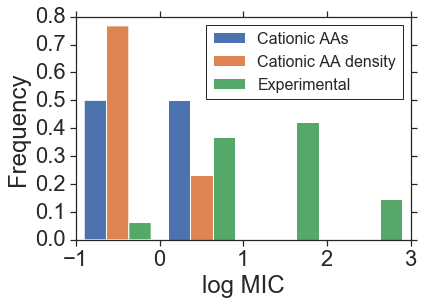

In [30]:
mic_labels = ['Cationic AAs','Cationic AA density','Experimental']
plt.hist([charge_constraint_pred_log_mic,charge_density_constraint_pred_log_mic,experimental_mic],normed=1,label=mic_labels,bins=range(-1,4))
plt.xlabel('log MIC')
plt.ylabel('Frequency')
plt.xticks(range(-1,4))
plt.legend(prop={'size':16})
plt.savefig('Figures/log_MIC_hist.png',bbox_inches='tight',frameon=False)
plt.show()

In [26]:
dataset_hmoments = [hmoment_analysis(seq) for seq in ecoli_df.sequence]

In [27]:
no_constraint_100 = [hmoments[1][0] for hmoments in no_constraint_hmoments]
charge_density_constraint_100 = [hmoments[1][0] for hmoments in charge_density_constraint_hmoments]
charge_constraint_100 = [hmoments[1][0] for hmoments in charge_constraint_hmoments]
dataset_100 = [hmoments[1][0] for hmoments in dataset_hmoments]

no_constraint_140 = [hmoments[1][1] for hmoments in no_constraint_hmoments]
charge_density_constraint_140 = [hmoments[1][1] for hmoments in charge_density_constraint_hmoments]
charge_constraint_140 = [hmoments[1][1] for hmoments in charge_constraint_hmoments]
dataset_140 = [hmoments[1][1] for hmoments in dataset_hmoments]

no_constraint_180 = [hmoments[1][3] for hmoments in no_constraint_hmoments]
charge_density_constraint_180 = [hmoments[1][3] for hmoments in charge_density_constraint_hmoments]
charge_constraint_180 = [hmoments[1][3] for hmoments in charge_constraint_hmoments]
dataset_180 = [hmoments[1][3] for hmoments in dataset_hmoments]

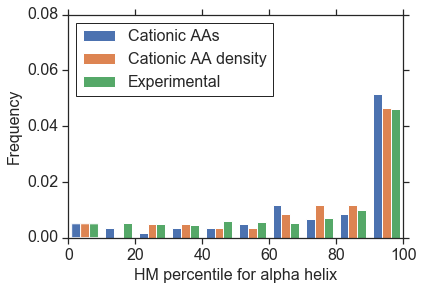

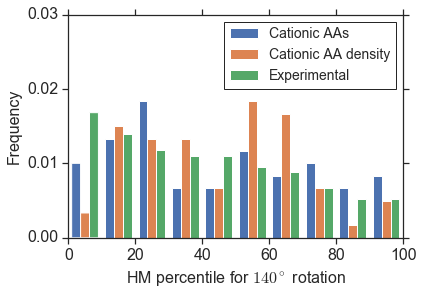

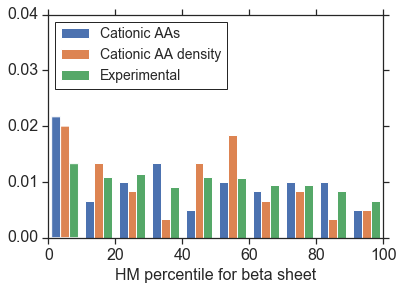

In [33]:
hmoment_labels = ['Cationic AAs','Cationic AA density','Experimental']

plt.hist([charge_density_constraint_100,charge_constraint_100,dataset_100],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for alpha helix',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks([0.02*i for i in range(5)],fontsize=16)
plt.legend()
plt.legend(loc='upper left',prop={'size':16})
plt.savefig('Figures/alpha_helix_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('')
plt.show()

plt.hist([charge_density_constraint_140,charge_constraint_140,dataset_140],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for $140^\circ$ rotation',fontsize=16)
plt.yticks([0.01*i for i in range(4)],fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.legend(loc='best',prop={'size':14})
plt.savefig('Figures/140_degree_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('Count')
plt.show()

plt.hist([charge_density_constraint_180,charge_constraint_180,dataset_180],bins=10,normed=1,label=hmoment_labels)
# plt.hist(,bins=20)
plt.xlabel('HM percentile for beta sheet',fontsize=16)
plt.yticks([0.01*i for i in range(5)],fontsize=16)
plt.xticks(fontsize=16)
plt.legend()
plt.legend(loc='upper left',prop={'size':14})
plt.savefig('Figures/beta_sheet_hmoment.png',bbox_inches='tight',frameon=False)
# plt.ylabel('Count')
plt.show()

# plt.hist(all_peptide_df['100_hmoment'],bins=20)
# plt.xlabel('HM for alpha helix')
# plt.ylabel('Count')
# plt.show()
# plt.hist(all_peptide_df['Pred_log_MIC'],bins=20)
# plt.xlabel('Predicted log MIC')
# plt.ylabel('Count')
# plt.show()

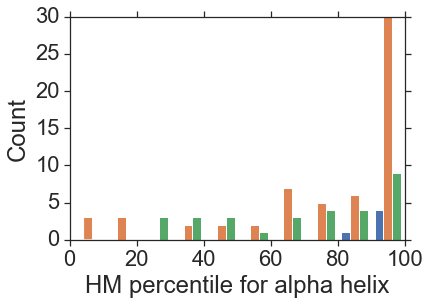

In [39]:
plt.hist([no_constraint_100,charge_density_constraint_100,charge_constraint_100],bins=10)
plt.xlabel('HM percentile for alpha helix')
plt.ylabel('Count')
plt.show()

In [117]:
# good_seqs = ['GWKVWKKILAKLAKLAK','WRRWWKILKAALAKLAK','WRWWKILKKLATVLKKLITLGTLA']
# good_seqs = good_seqs + ['RRWKWRKLAKVLTTLLRGGKRIQRL','WRKFWKKILKKLAKLAKTGLRKPII','GWRWWKKLAKVLAKLAK']
# good_seqs = ['WRKFLLKILKLLVQRYR','KWKKFWKVLKKVF']
# good_seqs = ['RRWKWRKLAKVLTTLLRGGKRIQRL','WRRWWKILKAALAKLAK','WRRWWKILKAALAKLAK','RKWIWWKLAKVLAKLAK','GFWKKILKKLATKLAKLAK']
good_seqs = ['RKWIWWKLAKVLAKLAK','GFWKKILKKLATKLAKLAK','GWKTLAKLAKKLAKLAK','WRKFWKKILKKLAKLAKTGLRKPII']
for seq in good_seqs:
    print all_peptide_df.loc[all_peptide_df.Sequence.str.contains(seq)]['Best_match']

51    DAHKLAKLAKKLAKLAK
Name: Best_match, dtype: object
73    DAHKLAKLAKKLAKLAK
Name: Best_match, dtype: object
7    DAHKLAKLAKKLAKLAK
Name: Best_match, dtype: object
89    KWKKLLKKLLKLPKKLLKKLKKLLK
Name: Best_match, dtype: object


In [218]:
print all_peptide_df.loc[all_peptide_df.Sequence.str.contains('DAHKLAKLAKKLAKLAK')]

Empty DataFrame
Columns: [level_0, 100_hmoment, 100_hmoment_percentile, Alignment_score, Best_match, Constraints, Cooling_function, Max_length, Min_length, Pred_log_MIC, Sequence, Sim_anneal_steps, index, t0, tf]
Index: []


In [119]:
# seq_matches = ['VNWKKILAKIIKVAK','KWWRWRRWW','KWKSFIKKLTSVLKKVVTTAKPLISS','FKCWRWQWRWKKLGAKVFKRLEKLFSKI','KWKKLLKKLLKLPKKLLKKLKKLLK','FKCWRWQWRWKKLGAKVFKRLEKLFSKI']
# seq_matches = ['KWKKLLKKLLKLL','KWKKFKKIGAVLKKL']
# seq_matches = ['FKCWRWQWRWKKLGAKVFKRLEKLFSKI','KWWRWRRWW','DAHKLAKLAKKLAKLAK']
seq_matches=['DAHKLAKLAKKLAKLAK','DAHKLAKLAKKLAKLAK','DAHKLAKLAKKLAKLAK','KWKKLLKKLLKLPKKLLKKLKKLLK']
for index,my_seq in enumerate(good_seqs):
    their_seq = seq_matches[index]
#     print df.loc[df.sequence.str.contains('KWKSFIKKLTSVLKKVVTTAKPLISS')]
    print 'Pam30 matrix:'
    alignment=pairwise2.align.localds(my_seq,their_seq,matlist.pam30,-9,-1)
    print pairwise2.format_alignment(*alignment[0])
#     print 'Identity matrix:'
#     alignment=pairwise2.align.localds(my_seq,their_seq,matlist.ident,-9,-1)
#     print pairwise2.format_alignment(*alignment[0])

Pam30 matrix:
RKWIWWKLAKVLAKLAK
      |||||||||||
DAHKLAKLAKKLAKLAK
  Score=58

Pam30 matrix:
GFWKKILKKLATKLAKLAK
        |||||||||||
--DAHKLAKLAKKLAKLAK
  Score=64

Pam30 matrix:
GWKTLAKLAKKLAKLAK
    |||||||||||||
DAHKLAKLAKKLAKLAK
  Score=87

Pam30 matrix:
WRKFWKKILKKLAKLAKTGLRKPII---
    ||||||||||||||||||
---KWKKLLKKLLKLPKKLLKKLKKLLK
  Score=68



# Performance of models

# First assemble decoy data

In [107]:
all_decoys = []
# fnames = ['Veltri_data/DECOY.eval.fa','Veltri_data/DECOY.te.fa','Veltri_data/DECOY.tr.fa']
fnames = ['Fasta_files/Uniprot_negatives.txt']
for fname in fnames:
    fasta_sequences=SeqIO.parse(fname,'fasta')
    for fasta in fasta_sequences:
        seq = str(fasta.seq)
        all_decoys.append(seq)
print len(all_decoys)
decoys_no_cysteine = []
for seq in all_decoys:
    if len(seq)>MAX_SEQUENCE_LENGTH:
        tries=0
        added = False
        while tries<15 and not added:
            start = random.randint(0,len(seq)-MAX_SEQUENCE_LENGTH)
            to_add = seq[start:(start+MAX_SEQUENCE_LENGTH)]
            tries += 1
            if 'C' not in to_add:
                decoys_no_cysteine.append(to_add)
                added = True
decoy_set = set(decoys_no_cysteine)

6329


In [65]:
def uniprot_testing_set(seqs,yvals,decoy_set,include_cysteine = True):
    deep_decoy_set = deepcopy(decoy_set)
#     print len(deep_decoy_set)
    lengths = []
    output_pos_seqs = []
    output_pos_yvals = []
    output_neg_seqs = []
    output_neg_yvals = []
    for i,seq in enumerate(seqs):
        if len(seq)<MAX_SEQUENCE_LENGTH:
            output_pos_seqs.append(seq)
            output_pos_yvals.append(yvals[i])
            output_neg_yvals.append(MAX_MIC)
#             print i
#             done = False
            alt_seq = ''
            for decoy_seq in deep_decoy_set:
#                 if len(decoy_seq) == len(seq):
#                     output_neg_seqs.append(decoy_seq)
#                     done = True
#                     deep_decoy_set.remove(decoy_seq)
#                     break
                if len(decoy_seq) >= len(seq):
                    alt_seq = decoy_seq
                    break
#             if not done:
            start = random.randint(0,len(alt_seq)-len(seq))
            output_neg_seqs.append(alt_seq[start:(start+len(seq))])
            deep_decoy_set.remove(alt_seq)
                
    return output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals

def random_testing_set(seqs,yvals,include_cysteine = True):
    lengths = []
    output_pos_seqs = []
    output_pos_yvals = []
    output_neg_seqs = []
    output_neg_yvals = []
    for i,seq in enumerate(seqs):
        if len(seq)<MAX_SEQUENCE_LENGTH:
            output_pos_seqs.append(seq)
            output_pos_yvals.append(yvals[i])
            output_neg_yvals.append(MAX_MIC)
            output_neg_seqs.append(generate_random_sequence(list(CHARACTER_DICT),include_C=False,fixed_length=len(seq),just_seq=True))
                
    return output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals

In [110]:
seqs = ecoli_test.reset_index().sequence
vals = ecoli_test.reset_index().value
output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = uniprot_testing_set(seqs,vals,decoy_set)
all_test_seqs = output_pos_seqs + output_neg_seqs
all_test_y_vals = output_pos_yvals + output_neg_yvals

p9_y_vals = []
p9_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p9_cutoff:
        p9_y_vals.append(vals[i])
        p9_seqs.append(seq)

p7_y_vals = []
p7_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p7_cutoff:
        p7_y_vals.append(vals[i])
        p7_seqs.append(seq)

output_pos_seqs_p9, output_neg_seqs_p9, output_pos_yvals_p9, output_neg_yvals_p9 = uniprot_testing_set(p9_seqs,p9_y_vals,decoy_set)
all_test_seqs_p9 = output_pos_seqs_p9 + output_neg_seqs_p9
all_test_y_vals_p9 = output_pos_yvals_p9 + output_neg_yvals_p9
# print len(all_test_seqs_p9)
# print len(output_pos_seqs_p9)

output_pos_seqs_p7, output_neg_seqs_p7, output_pos_yvals_p7, output_neg_yvals_p7 = uniprot_testing_set(p7_seqs,p7_y_vals,decoy_set)
all_test_seqs_p7 = output_pos_seqs_p7 + output_neg_seqs_p7
all_test_y_vals_p7 = output_pos_yvals_p7 + output_neg_yvals_p7
# print len(all_test_seqs_p7)
# print len(output_pos_seqs_p7)


vectors_with_uniprot = []
for i,seq in enumerate(all_test_seqs):
    vectors_with_uniprot.append(sequence_to_vector(seq,False))
vectors_with_uniprot = np.array(vectors_with_uniprot)

vectors_with_uniprot_p9 = []
for i,seq in enumerate(all_test_seqs_p9):
    vectors_with_uniprot_p9.append(sequence_to_vector(seq,False))
vectors_with_uniprot_p9 = np.array(vectors_with_uniprot_p9)

vectors_with_uniprot_p7 = []
for i,seq in enumerate(all_test_seqs_p7):
    vectors_with_uniprot_p7.append(sequence_to_vector(seq,False))
vectors_with_uniprot_p7 = np.array(vectors_with_uniprot_p7)

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot))
output_file = open('Figures/predictions_vs_uniprot.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in vectors_with_uniprot:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_uniprot.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot))
output_file = open('Figures/predictions_vs_uniprot_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot_p9))
output_file_p9 = open('Figures/predictions_vs_uniprot_p9.csv','w')
output_file_p9.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p9):
    amp = vector_to_amp(testx)
    output_file_p9.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p9[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p9.write(repr(all_preds[k][i])+',')
    output_file_p9.write('\n')
output_file_p9.close()

seqs_for_fasta = []
for vect in vectors_with_uniprot_p9:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_uniprot_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_uniprot_p7))
output_file_p7 = open('Figures/predictions_vs_uniprot_p7.csv','w')
output_file_p7.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p7):
    amp = vector_to_amp(testx)
    output_file_p7.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p7[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p7.write(repr(all_preds[k][i])+',')
    output_file_p7.write('\n')
output_file_p7.close()

seqs_for_fasta = []
for vect in vectors_with_uniprot_p7:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_uniprot_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

6138
6138
392
196
6138
192
96


In [50]:
all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot_p9))
output_file = open('Figures/predictions_vs_uniprot_p9_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random_p9))
output_file = open('Figures/predictions_vs_random_p9_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_uniprot_p7))
output_file = open('Figures/predictions_vs_uniprot_p7_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_uniprot_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random_p7))
output_file = open('Figures/predictions_vs_random_p7_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p9):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

NameError: name 'vectors_with_uniprot_p9' is not defined

In [47]:
seqs = ecoli_test.reset_index().sequence
vals = ecoli_test.reset_index().value
output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = random_testing_set(seqs,vals)
all_test_seqs = output_pos_seqs + output_neg_seqs
all_test_y_vals = output_pos_yvals + output_neg_yvals

p9_y_vals = []
p9_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p9_cutoff:
        p9_y_vals.append(vals[i])
        p9_seqs.append(seq)

p7_y_vals = []
p7_seqs = []
for i,seq in enumerate(seqs):
    if seq in seqs_p7_cutoff:
        p7_y_vals.append(vals[i])
        p7_seqs.append(seq)

output_pos_seqs_p9, output_neg_seqs_p9, output_pos_yvals_p9, output_neg_yvals_p9 = random_testing_set(p9_seqs,p9_y_vals)
all_test_seqs_p9 = output_pos_seqs_p9 + output_neg_seqs_p9
all_test_y_vals_p9 = output_pos_yvals_p9 + output_neg_yvals_p9
# print len(all_test_seqs_p9)
# print len(output_pos_seqs_p9)

output_pos_seqs_p7, output_neg_seqs_p7, output_pos_yvals_p7, output_neg_yvals_p7 = random_testing_set(p7_seqs,p7_y_vals)
all_test_seqs_p7 = output_pos_seqs_p7 + output_neg_seqs_p7
all_test_y_vals_p7 = output_pos_yvals_p7 + output_neg_yvals_p7
# print len(all_test_seqs_p7)
# print len(output_pos_seqs_p7)


vectors_with_random = []
for i,seq in enumerate(all_test_seqs):
    vectors_with_random.append(sequence_to_vector(seq,False))
vectors_with_random = np.array(vectors_with_random)

vectors_with_random_p9 = []
for i,seq in enumerate(all_test_seqs_p9):
    vectors_with_random_p9.append(sequence_to_vector(seq,False))
vectors_with_random_p9 = np.array(vectors_with_random_p9)

vectors_with_random_p7 = []
for i,seq in enumerate(all_test_seqs_p7):
    vectors_with_random_p7.append(sequence_to_vector(seq,False))
vectors_with_random_p7 = np.array(vectors_with_random_p7)

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random))
output_file = open('Figures/predictions_vs_random.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in vectors_with_random:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_random.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list_avgs:
    all_preds.append(emodel.predict(vectors_with_random))
output_file = open('Figures/predictions_vs_random_avgs.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random_p9))
output_file_p9 = open('Figures/predictions_vs_random_p9.csv','w')
output_file_p9.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p9):
    amp = vector_to_amp(testx)
    output_file_p9.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p9[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p9.write(repr(all_preds[k][i])+',')
    output_file_p9.write('\n')
output_file_p9.close()

seqs_for_fasta = []
for vect in vectors_with_random_p9:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_random_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(vectors_with_random_p7))
output_file_p7 = open('Figures/predictions_vs_random_p7.csv','w')
output_file_p7.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(vectors_with_random_p7):
    amp = vector_to_amp(testx)
    output_file_p7.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(all_test_y_vals_p7[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file_p7.write(repr(all_preds[k][i])+',')
    output_file_p7.write('\n')
output_file_p7.close()

seqs_for_fasta = []
for vect in vectors_with_random_p7:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_vs_random_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

# OCNN based classification

In [145]:
from sklearn.metrics import matthews_corrcoef

In [61]:
ecoli_train_train_no_c = pd.read_pickle('Saved_variables/ecoli_train_train_no_c_df.pkl')
ecoli_validate_no_c = pd.read_pickle('Saved_variables/ecoli_validate_no_c_df.pkl')

In [132]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def nn_distance(seq,seq_db):
    min_dist = 100
    for seq_in_db in seq_db:
        dist = levenshtein(seq,seq_in_db)
        min_dist = min(dist,min_dist)
    return min_dist

def knn_distances(seq,seq_db,k):
    min_dists = [100]*k
    for seq_in_db in seq_db:
        dist = levenshtein(seq,seq_in_db)
        for i,min_dist in enumerate(min_dists):
            if dist<min_dist:
                min_dists[i]=dist
                break
    return min_dists

def avg_knn_distance(seq,seq_db,k):
    return np.mean(knn_distances(seq,seq_db,k))

def kjnn_distance_ratio(seq,seq_db,j,k):
    min_dists = [100]*j
    min_dist_seqs = [' ']*j
    for i,seq_in_db in enumerate(seq_db):
        dist = levenshtein(seq,seq_in_db)
        for ind,min_dist in enumerate(min_dists):
            if dist<min_dist:
                min_dists[ind]=dist
                min_dist_seqs[ind]=seq_in_db
                break
    second_neighbor_dists = []
    for second_seq in min_dist_seqs:
        second_neighbor_dists.append(avg_knn_distance(second_seq,seq_db,k+1)*float(k+1)/float(k))
    return np.mean(min_dists),np.mean(second_neighbor_dists),np.mean(min_dists)/np.mean(second_neighbor_dists)


In [81]:
seqs = ecoli_validate_no_c.reset_index(drop=True).sequence
vals = ecoli_validate_no_c.reset_index(drop=True).value
nn_seq_db = ecoli_train_train_no_c.reset_index(drop=True).sequence
# output_pos_seqs, output_neg_seqs, output_pos_yvals, output_neg_yvals = random_testing_set(seqs,vals)

In [83]:
pos_dists = []
for seq in output_pos_seqs:
    pos_dists.append(nn_distance(seq,nn_seq_db))

In [84]:
neg_dists = []
for seq in output_neg_seqs:
    neg_dists.append(nn_distance(seq,nn_seq_db))

In [87]:
output_file = open('Figures/ocnn_validation_distances.csv','w')
output_file.write('Sequence,Is_AMP,Min_distance\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+'\n')
output_file.close()

In [148]:
k=3
pos_dists = []
for seq in output_pos_seqs:
    pos_dists.append(avg_knn_distance(seq,nn_seq_db,k))
neg_dists = []
for seq in output_neg_seqs:
    neg_dists.append(avg_knn_distance(seq,nn_seq_db,k))
output_file = open('Figures/ocnn_validation_distances_k_'+repr(k)+'.csv','w')
output_file.write('Sequence,Is_AMP,Avg_distance\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+'\n')
output_file.close()

In [138]:
# Compute MCC as a function of distance ratio cutoffs, used for the general JKNN approach described in Khan & Ahmad
# Note: Khan and Ahmad say "In this section, we will show that varying
# decision threshold (θ) with 11NN is similar to other OCNN
# methods discussed in Section 3." So there's not too much point going beyond the 11NN approach we use here
k=1
j=1
pos_ratios = []
pos_dists = []
pos_second_order_dists=[]
for seq in output_pos_seqs:
    first,second,ratio=kjnn_distance_ratio(seq,nn_seq_db,k,j)
    pos_dists.append(first)
    pos_second_order_dists.append(second)
    pos_ratios.append(ratio)
neg_dists = []
neg_ratios=[]
neg_second_order_dists=[]
for seq in output_neg_seqs:
    first,second,ratio=kjnn_distance_ratio(seq,nn_seq_db,k,j)
    neg_dists.append(first)
    neg_second_order_dists.append(second)
    neg_ratios.append(ratio)
output_file = open('Figures/ocnn_validation_distances_k_'+repr(k)+'_j_'+repr(j)+'.csv','w')
output_file.write('Sequence,Is_AMP,First_order_distance,Second_order_distance,Ratio\n')
for i,seq in enumerate(output_pos_seqs):
    output_file.write(seq+',1,'+repr(pos_dists[i])+','+repr(pos_second_order_dists[i])+','+repr(pos_ratios[i])+'\n')
for i,seq in enumerate(output_neg_seqs):
    output_file.write(seq+',0,'+repr(neg_dists[i])+','+repr(neg_second_order_dists[i])+','+repr(neg_ratios[i])+'\n')
output_file.close()

In [144]:
# Compute MCC as a function of distance ratio cutoffs, used for the general JKNN approach described in Khan & Ahmad
ratio_cutoffs = [float(i)*0.1 for i in range(50)]
actual_y = [1]*len(pos_ratios)+[0]*len(neg_ratios)
for cutoff in ratio_cutoffs:
    pred_y = []
    for ratio in pos_ratios:
        if ratio>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    for ratio in neg_ratios:
        if ratio>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    print repr(cutoff)+','+repr(matthews_corrcoef(actual_y,pred_y))

0.0,0.0
0.1,0.0893633203101749
0.2,0.18603327355791477
0.30000000000000004,0.21680546186600297
0.4,0.295095475588696
0.5,0.41698016054566356
0.6000000000000001,0.42862849150431487
0.7000000000000001,0.45016084318200866
0.8,0.46714540319697834
0.9,0.46334476192157265
1.0,0.704588342040123
1.1,0.7001693961917852
1.2000000000000002,0.6727717549749973
1.3,0.6530764724142323
1.4000000000000001,0.6327282401449621
1.5,0.6147083409871212
1.6,0.5990642969427735
1.7000000000000002,0.5910440629174544
1.8,0.5510981899001854
1.9000000000000001,0.531703325479019
2.0,0.5704064516694177
2.1,0.5687686877639309
2.2,0.5611996165371981
2.3000000000000003,0.5440555236240655
2.4000000000000004,0.5295768948359719
2.5,0.5213150022643175
2.6,0.5181465517795235
2.7,0.5138638690716287
2.8000000000000003,0.4933451358602039
2.9000000000000004,0.4901917804148775
3.0,0.49036536150062904
3.1,0.49036536150062904
3.2,0.4888195819332791
3.3000000000000003,0.48727369001661547
3.4000000000000004,0.4817441376771243
3.5,0.4

In [149]:
# Compute MCC as a function of just nearest neighbor distances (a simper version, basically a KNN approach as opposed to a JKNN approach)
distance_cutoffs = [i+0.5 for i in range(30)]
actual_y = [1]*len(pos_dists)+[0]*len(neg_dists)
for cutoff in distance_cutoffs:
    pred_y = []
    for dist in pos_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    for dist in neg_dists:
        dist=float(dist)
        if dist>cutoff:
            pred_y.append(0)
        else:
            pred_y.append(1)
    print repr(cutoff)+','+repr(matthews_corrcoef(actual_y,pred_y))

0.5,0.0
1.5,0.2503505493659249
2.5,0.4466348499258364
3.5,0.5404902024634002
4.5,0.6021647484782663
5.5,0.6282053912783216
6.5,0.6010740850902723
7.5,0.5853240297185915
8.5,0.5226974200483592
9.5,0.4486792389748489
10.5,0.4152850538448628
11.5,0.39713843859308706
12.5,0.38762970280973935
13.5,0.37296828874493004
14.5,0.3472709886762155
15.5,0.3013484183016404
16.5,0.26056540536578277
17.5,0.22265667468430905
18.5,0.21074534790953292
19.5,0.17561904209251447
20.5,0.15174260392331915
21.5,0.13127625787762592
22.5,0.14020463805614447
23.5,0.14588202334446548
24.5,0.13466807939045775
25.5,0.13125256355166678
26.5,0.12048289933537483
27.5,0.1033254885477436
28.5,0.0842151921066519
29.5,0.0664895968541847


In [107]:
# fasta_fnames_to_test = ['test_fasta_with_negatives_vs_random_p7.txt']
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_random_p9.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_random.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot_p7.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot_p9.txt')
fasta_fnames_to_test.append('test_fasta_with_negatives_vs_uniprot.txt')
# output_fnames = ['ocnn_random_p7.csv']
output_fnames.append('ocnn_random_p9.csv')
output_fnames.append('ocnn_random_all.csv')
output_fnames.append('ocnn_uniprot_p7.csv')
output_fnames.append('ocnn_uniprot_p9.csv')
output_fnames.append('ocnn_uniprot_all.csv')

In [105]:
train_seq_db = ecoli_train_with_c.sequence

In [108]:
threshold=4.5
for i,name in enumerate(fasta_fnames_to_test):
    seqs_to_test = fasta_to_seqs('Fasta_files/Good_fasta_files_with_negatives/'+name)
    output_file = open('Figures/'+output_fnames[i],'w')
    output_file.write('Sequence,Min_distance,Is_pred_AMP\n')
    for seq in seqs_to_test:
        dist = nn_distance(seq,train_seq_db)
        is_pred_amp = 0
        if dist<threshold:
            is_pred_amp=1
        output_file.write(seq+','+repr(dist)+','+repr(is_pred_amp)+'\n')
    output_file.close()

# Make ROC curves

In [109]:
import xlrd
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [110]:
algorithm_names = ['Our model','OCNN','AMP scanner v2','iAMPpred','CAMP SVM','CAMP RF','CAMP ANN','CAMP DA']

In [112]:
uniprot_fname = 'Figures/Saved_predictions/Uniprot_combined_p9_predictions.xlsx'
uniprot_wkbk = xlrd.open_workbook(uniprot_fname)
uniprot_sheet = uniprot_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,uniprot_sheet.ncols)]

for row_ind in range(1,uniprot_sheet.nrows):
    row = uniprot_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,uniprot_sheet.ncols):
        if col_ind==1 or col_ind==2:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

uniprot_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
uniprot_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (uniprot_roc_aucs)

[0.9660558100791338, 0.8194111828404831, 0.9752186588921283, 0.9446584756351519, 0.9212177217825905, 0.9613832778009164, 0.895408163265306, 0.9636089129529363]


In [ ]:
[0.9660558100791338, 0.9752186588921283, 0.9446584756351519, 0.9212177217825905, 0.9613832778009164, 0.895408163265306, 0.9636089129529363]

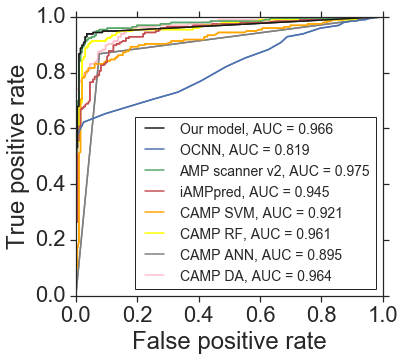

In [113]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%uniprot_roc_aucs[i] for i in range(len(uniprot_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray','pink']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(uniprot_rocs)):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(uniprot_rocs))):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures/Uniprot_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [131]:
uniprot_fname = 'Figures/Saved_predictions/Uniprot_combined_predictions.xlsx'
uniprot_wkbk = xlrd.open_workbook(uniprot_fname)
uniprot_sheet = uniprot_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,uniprot_sheet.ncols)]

for row_ind in range(1,uniprot_sheet.nrows):
    row = uniprot_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,uniprot_sheet.ncols):
        if col_ind==1 or col_ind==2:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

uniprot_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
uniprot_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (uniprot_roc_aucs)

[0.9730523170589677, 0.9777229810322048, 0.9742671716177846]


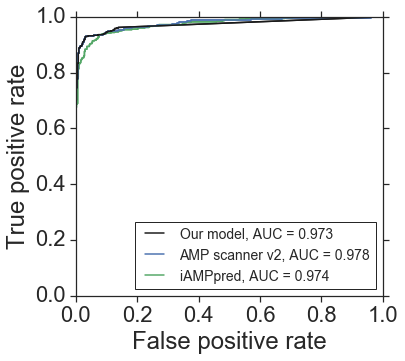

In [134]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%uniprot_roc_aucs[i] for i in range(len(random_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(uniprot_rocs)):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(uniprot_rocs))):
    plt.plot(uniprot_rocs[i][0],uniprot_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures/Uniprot_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [115]:
random_fname = 'Figures/Saved_predictions/Random_combined_p9_predictions.xlsx'
random_wkbk = xlrd.open_workbook(random_fname)
random_sheet = random_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,random_sheet.ncols)]

for row_ind in range(1,random_sheet.nrows):
    row = random_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,random_sheet.ncols):
        if col_ind==1 or col_ind==2:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

random_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
random_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (random_roc_aucs)

[0.9729539775093712, 0.8299796959600168, 0.9615004164931279, 0.9106882548937942, 0.9459860474802165, 0.9693356934610577, 0.8928571428571428, 0.9740082257392755]


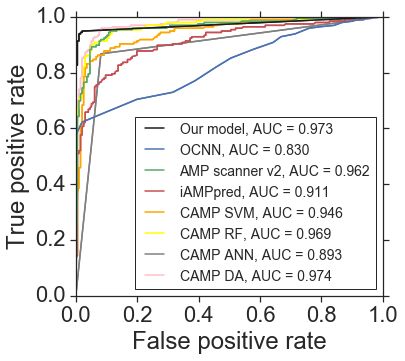

In [116]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%random_roc_aucs[i] for i in range(len(random_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray','pink']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(random_rocs)):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(random_rocs))):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures/Random_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

In [128]:
random_fname = 'Figures/Saved_predictions/Random_combined_predictions.xlsx'
random_wkbk = xlrd.open_workbook(random_fname)
random_sheet = random_wkbk.sheet_by_name('All_predictions')
y_true=[]
y_guesses = [[] for i in range(1,random_sheet.ncols)]

for row_ind in range(1,random_sheet.nrows):
    row = random_sheet.row_values(row_ind)
    y_true_log_mic = row[0]
    if y_true_log_mic > 3.99:
        y_true.append(0)
    else:
        y_true.append(1)
    for col_ind in range(1,random_sheet.ncols):
        if col_ind==1 or col_ind==2:
            y_guesses[col_ind-1].append(-row[col_ind])
        else:
            y_guesses[col_ind-1].append(row[col_ind])

random_rocs = [roc_curve(y_true,y_guesses[i]) for i in range(len(y_guesses))]
random_roc_aucs = [roc_auc_score(y_true,y_guesses[i]) for i in range(len(y_guesses))]
print (random_roc_aucs)

[0.9794097212460994, 0.991236982984004, 0.9681848667274429]


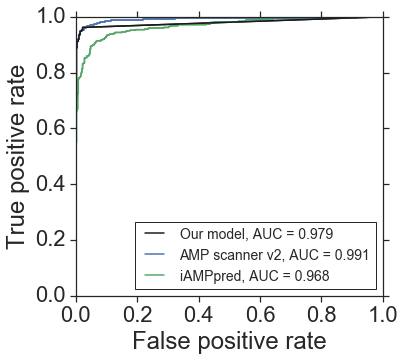

In [129]:
labels = [algorithm_names[i]+', AUC = '+'%.3f'%random_roc_aucs[i] for i in range(len(random_roc_aucs))]
colors = ['k','b','g','r','orange','yellow','gray']
plt.figure(figsize=[5.5,5])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# plt.plot([0,1],[0,1],'--',color='gray')
for i in range(len(random_rocs)):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i],label=labels[i])
for i in reversed(range(len(random_rocs))):
    plt.plot(random_rocs[i][0],random_rocs[i][1],'-',color=colors[i])
plt.legend(loc=4,prop={'size':14})
plt.savefig('Figures/Random_p9_roc_curves.png',bbox_inches='tight',frameon=False)
plt.show()

## First assemble all the ensemble models

In [23]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
ENSEMBLE_SIZE=5
NEG_RATIOS = [1,3,10]
with_C_weights = []
with_C_architectures = []
no_C_weights = []
no_C_architectures = []
for k in range(len(NEG_RATIOS)):
    with_C_weights.append(['train_ensemble_weights_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    with_C_architectures.append(['train_ensemble_architecture_withC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])
    no_C_weights.append(['train_ensemble_weights_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.h5' for i in range(ENSEMBLE_SIZE)])
    no_C_architectures.append(['train_ensemble_architecture_noC_'+repr(NEG_RATIOS[k])+'xneg_'+repr(i)+'.json' for i in range(ENSEMBLE_SIZE)])

    
with_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
no_c_ensembles = [[] for i in range(len(NEG_RATIOS))]
for k in range(len(NEG_RATIOS)):
    for i in range(len(with_C_weights[0])):
        with open('Saved_models/'+with_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+with_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        with_c_ensembles[k].append(reconst_model)    

        with open('Saved_models/'+no_C_architectures[k][i],'r') as f:
            reconst_model = model_from_json(f.read())
        reconst_model.load_weights('Saved_models/'+no_C_weights[k][i])
        reconst_model.compile(loss='mean_squared_error',optimizer='adam')
        no_c_ensembles[k].append(reconst_model)
        
# everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')  

In [154]:
no_c_ensemble_models = [EnsembleModel(no_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_models = [EnsembleModel(with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
no_c_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
with_c_ensemble_model_avgs = [EnsembleModel(with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]
all_ensemble_models = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'classify_then_average') for k in range(len(NEG_RATIOS))]
all_ensemble_model_avgs = [EnsembleModel(no_c_ensembles[k]+with_c_ensembles[k],'average') for k in range(len(NEG_RATIOS))]

everything_ensemble_model = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'classify_then_average')  
everything_ensemble_model_avg = EnsembleModel(no_c_ensembles[0]+with_c_ensembles[0]+no_c_ensembles[1]+with_c_ensembles[1]+no_c_ensembles[2]+with_c_ensembles[2],'average')

ensemble_model_list = no_c_ensemble_models+with_c_ensemble_models+[everything_ensemble_model]
ensemble_model_list_avgs = no_c_ensemble_model_avgs + with_c_ensemble_model_avgs + [everything_ensemble_model_avg]

In [142]:
for k in range(len(NEG_RATIOS)):
#     print no_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
#     print no_c_ensemble_models[k].evaluate(test_x,test_y)
    a,b,c,d = with_c_ensemble_models[k].evaluate_as_classifier(test_x_with_negatives,test_y_with_negatives)
    print with_c_ensemble_models[k].evaluate_as_classifier(test_x_with_negatives,test_y_with_negatives)
    print 'False negative rate: '+repr(float(d)/a)
    print 'False positive rate: '+repr(float(c)/b)

(494, 480, 29, 15)
False negative rate: 0.030364372469635626
False positive rate: 0.06041666666666667
(489, 502, 7, 20)
False negative rate: 0.0408997955010225
False positive rate: 0.013944223107569721
(479, 504, 5, 30)
False negative rate: 0.06263048016701461
False positive rate: 0.00992063492063492


In [135]:
for k in range(len(NEG_RATIOS)):
#     print no_c_ensemble_models[k].evaluate_as_classifier(test_x,test_y)
#     print no_c_ensemble_models[k].evaluate(test_x,test_y)
    a,b,c,d = with_c_ensemble_models[k].evaluate_as_classifier(test_x_with_negatives,test_y_with_negatives)
    print with_c_ensemble_models[k].evaluate_as_classifier(test_x_with_negatives,test_y_with_negatives)
    print 'False negative rate: '+repr(float(d)/a)
    print 'False positive rate: '+repr(float(c)/b)

(494, 483, 26, 15)
False negative rate: 0.030364372469635626
False positive rate: 0.053830227743271224
(489, 503, 6, 20)
False negative rate: 0.0408997955010225
False positive rate: 0.011928429423459244
(479, 507, 2, 30)
False negative rate: 0.06263048016701461
False positive rate: 0.0039447731755424065


In [138]:
blah = [vector_to_amp(testx) for testx in ecoli_test_input_with_negatives[0][509:]]
print len(blah)
print blah[0]
counter = 0
for thing in blah:
    if thing['cterminal_amidation']:
        counter+=1
print counter
print float(counter)/len(blah)

509
{'cterminal_amidation': True, 'sequence': u'AGYRGVVRHQAYGWPPTIVTPGTRRRTIRHINDDEVFSH_______'}
235
0.461689587426


In [34]:
train_fasta = seqs_to_fasta(ecoli_train_with_c['sequence'])
test_fasta = seqs_to_fasta(ecoli_test['sequence'])

In [36]:
train_file = open('Fasta_files/train_fasta.txt','w')
train_file.write(train_fasta)
train_file.close()
test_file = open('Fasta_files/test_fasta.txt','w')
test_file.write(test_fasta)
test_file.close()

## Now remove sequences at http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit-2d

### Sequence identity cutoffs to run with: 0.9 and 0.7

### Otherwise: just use the defaults

In [167]:
seqs_p9_cutoff = fasta_to_seqs('Fasta_files/p9_identity.txt')
seqs_p7_cutoff = fasta_to_seqs('Fasta_files/p7_identity.txt')

In [181]:
indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_not_too_long = ecoli_test.iloc[indices].reset_index(drop=True)

In [182]:
indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if seq in seqs_p9_cutoff and len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_p9 = ecoli_test.iloc[indices]

indices = []
for i,seq in enumerate(ecoli_test['sequence']):
    if seq in seqs_p7_cutoff and len(seq)<MAX_SEQUENCE_LENGTH:
        indices.append(i)
ecoli_test_p7 = ecoli_test.iloc[indices]

In [130]:
seqs = ecoli_df.sequence
lengths = [min(MAX_SEQUENCE_LENGTH,len(seq)) for seq in seqs]
SEQ_LENGTHS = lengths
ecoli_test_input = df_to_input_vec(ecoli_test)
ecoli_test_input_with_negatives = add_random_negative_examples(ecoli_test_input[0],ecoli_test_input[1],ecoli_test_input[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)
ecoli_test_input_p9 = df_to_input_vec(ecoli_test_p9)
ecoli_test_input_with_negatives_p9 = add_random_negative_examples(ecoli_test_input_p9[0],ecoli_test_input_p9[1],ecoli_test_input_p9[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)
ecoli_test_input_p7 = df_to_input_vec(ecoli_test_p7)
ecoli_test_input_with_negatives_p7 = add_random_negative_examples(ecoli_test_input_p7[0],ecoli_test_input_p7[1],ecoli_test_input_p7[2],ratio=1,max_mic=MAX_MIC,include_cysteine=False)


test_x_with_negatives = ecoli_test_input_with_negatives[0]
test_y_with_negatives = ecoli_test_input_with_negatives[1]
test_x_p9_with_negatives = ecoli_test_input_with_negatives_p9[0]
test_y_p9_with_negatives = ecoli_test_input_with_negatives_p9[1]
test_x_p7_with_negatives = ecoli_test_input_with_negatives_p7[0]
test_y_p7_with_negatives = ecoli_test_input_with_negatives_p7[1]

ecoli_test_input = df_to_input_vec(ecoli_test_not_too_long)
test_x = ecoli_test_input[0]
test_y = ecoli_test_input[1]
test_x_p9 = ecoli_test_input_p9[0]
test_y_p9 = ecoli_test_input_p9[1]
test_x_p7 = ecoli_test_input_p7[0]
test_y_p7 = ecoli_test_input_p7[1]

NameError: name 'ecoli_test_p9' is not defined

In [185]:
avg_pred = everything_ensemble_model_avg.predict(test_x_with_negatives)

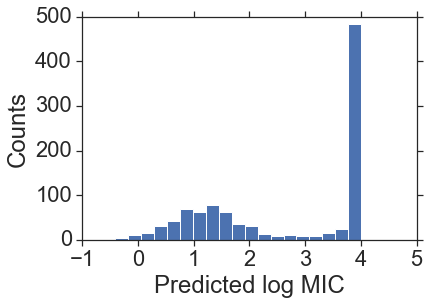

In [186]:
plt.hist(avg_pred,bins=20)
plt.xlabel('Predicted log MIC')
plt.ylabel('Counts')
plt.show()

In [59]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_with_negatives))
output_file = open('Figures/predictions.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives.txt','w')
test_file.write(for_fasta)
test_file.close()

In [60]:
test_x_with_negatives_no_amidation = wipe_out_amidation(test_x_with_negatives)
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_with_negatives_no_amidation))
output_file = open('Figures/predictions_no_amidation.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_with_negatives_no_amidation):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()

In [61]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_p9_with_negatives))
output_file = open('Figures/predictions_p9.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_p9_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_p9_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_p9_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_p9.txt','w')
test_file.write(for_fasta)
test_file.close()

In [62]:
all_preds=[]
for emodel in ensemble_model_list:
    all_preds.append(emodel.predict(test_x_p7_with_negatives))
output_file = open('Figures/predictions_p7.csv','w')
output_file.write('Sequence,Amidation,Actual,No_C_1,No_C_3,No_C_10,With_C_1,With_C_3,With_C_10,All\n')
for i,testx in enumerate(test_x_p7_with_negatives):
    amp = vector_to_amp(testx)
    output_file.write(repr(amp['sequence'])+','+repr(amp['cterminal_amidation'])+','+repr(test_y_p7_with_negatives[i])+',')
    for k in range(len(ensemble_model_list)):
#         print all_preds
        output_file.write(repr(all_preds[k][i])+',')
    output_file.write('\n')
output_file.close()
seqs_for_fasta = []
for vect in test_x_p7_with_negatives:
    seq = vector_to_amp(vect)['sequence']
    if seq.find('_')>-1:
        seq = seq[0:seq.find('_')]
    seqs_for_fasta.append(seq)
for_fasta = seqs_to_fasta(seqs_for_fasta)
test_file = open('Fasta_files/test_fasta_with_negatives_p7.txt','w')
test_file.write(for_fasta)
test_file.close()

# Regression performance

In [188]:
all_predicted = everything_ensemble_model_avg.predict(test_x)
p7_predicted = everything_ensemble_model_avg.predict(test_x_p7)
p9_predicted = everything_ensemble_model_avg.predict(test_x_p9)

In [205]:
def evaluate_predictions(predicted,test_y):
    tau,pval = kendalltau(predicted,test_y)
    mse = 'MSE,'+repr(float(np.average([(predicted[i]-test_y[i])**2 for i in range(len(test_y))])))
    pearson = 'Pearson,'+repr(float(np.corrcoef(predicted,test_y)[1,0]))
    tau = 'Kendall tau,'+repr(tau)
    print mse+','+pearson+','+tau+','

In [207]:
evaluate_predictions(all_predicted,test_y)
evaluate_predictions(p9_predicted,test_y_p9)
evaluate_predictions(p7_predicted,test_y_p7)

MSE,0.4934553546380381,Pearson,0.6412366631301024,Kendall tau,0.5469008803272578,
MSE,0.7038468690674359,Pearson,0.5120939644800396,Kendall tau,0.47654804384967014,
MSE,1.1966017154594863,Pearson,0.3429843289271072,Kendall tau,0.32317841255153623,


In [191]:
print np.corrcoef(all_predicted,test_y)
print np.corrcoef(p9_predicted,test_y_p9)
print np.corrcoef(p7_predicted,test_y_p7)

[[1.         0.64123666]
 [0.64123666 1.        ]]
[[1.         0.51209396]
 [0.51209396 1.        ]]
[[1.         0.34298433]
 [0.34298433 1.        ]]


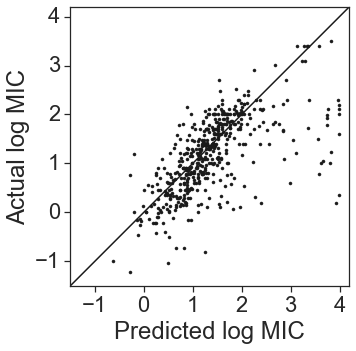

In [190]:
# plt.set(font_scale=1,style='white',font='Arial')
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(all_predicted,test_y,'.',color='k')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
plt.savefig('Figures/pred_vs_actual_all.png',bbox_inches='tight',frameon=False)
plt.show()

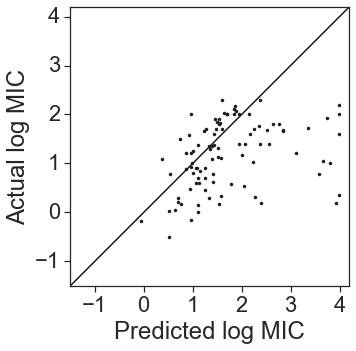

In [197]:
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(p7_predicted,test_y_p7,'k.')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
ax.set_aspect('equal')
plt.savefig('Figures/pred_vs_actual_p7.png',bbox_inches='tight',frameon=False)
plt.show()

In [167]:
len(p7_predicted)

103

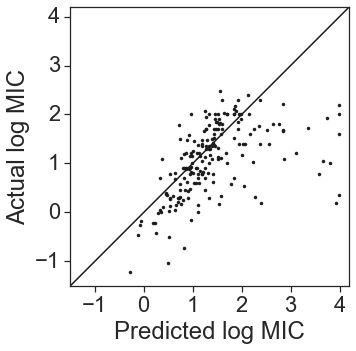

In [198]:
font_to_use = {'fontname':FONT_TO_USE}
f, ax = plt.subplots(figsize=(5,5))
plt.plot(p9_predicted,test_y_p9,'k.')
plt.plot([-2,4.2],[-2,4.2],'k-')
plt.xlabel('Predicted log MIC',**font_to_use)
plt.ylabel('Actual log MIC',**font_to_use)
plt.ylim(-1.5,4.2)
plt.xlim(-1.5,4.2)
for tick in ax.get_xticklabels():
    tick.set_fontname(FONT_TO_USE)
for tick in ax.get_yticklabels():
    tick.set_fontname(FONT_TO_USE)
plt.tick_params(top='off',right='off')
ax.set_aspect('equal')
plt.savefig('Figures/pred_vs_actual_p9.png',bbox_inches='tight',frameon=False)
plt.show()